In [1]:
# keras back-end is different from tensorflow-keras back-end (using entire tensorflow API for stable compatibility)
# some errors like weight couldn't be save correctly or pre-trained model weight not save the latest after training is due to
# keras back-end not compatible with some framework like hugging-face ...


import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from tensorflow import keras
# from keras import *
# from keras.layers import *
import math

import numpy as np
import matplotlib.pyplot as plt

import datetime
import pathlib
import io
from datetime import datetime
import os
import shutil
import time
import random
import cv2 as cv

2025-05-07 16:10:12.579143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746634212.778476      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746634212.831362      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def patchify(x, r, stride, return_spatial_info=False):
    shapes = tf.shape(x)
    batch, height, width, channels = shapes[0], shapes[1], shapes[2], shapes[3]
    num_patches = height * width

    
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, r, r, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )
 
    patches = tf.reshape(patches, (batch, num_patches, -1))
    patches = tf.reshape(patches, (batch, num_patches, r, r, channels))

    if return_spatial_info:
        return patches, (patch_height, patch_width)
    return patches

In [ ]:
class AdaptivePooling1D(layers.Layer):
    def __init__(self, output_size, **kwargs,):
        self.output_size = output_size
        super().__init__(**kwargs)

    def call(self, inputs, *args):
        bins = self.output_size
        
        splits = tf.split(inputs, bins, axis=-1)
        splits = tf.stack(splits, axis=-1)
        out_vect = tf.reduce_mean(splits, axis=3)
        tf.print(tf.shape(out_vect))
      
        return out_vect

In [ ]:
import os
os._exit(00)

In [2]:
DATA_PATH = '/kaggle/input/mvtec-ad/'
# DATA_PATH = '/kaggle/input/'

IM_SIZE = 384
SCALE = int(IM_SIZE*550/512)
PATCH_SIZE = 32

BATCH_SIZE = 8
N_CLASSES = 15


In [ ]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(int(0.2*IM_SIZE), int(0.8*IM_SIZE)).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(int(0.2*IM_SIZE), int(0.8*IM_SIZE)).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

def cutmix(train_dataset_1, train_dataset_2):
  image_1 = train_dataset_1, 
  image_2 = train_dataset_2

  # lamda = tfp.distributions.Beta(1,1)
  # lamda = lamda.sample(1)[0]
  lamda =0.7
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)
    
  image = image_1 - pad_1 #+ 0.5*pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)

  return image[0], image_2

In [3]:
def create_dataset(data_subset='train', categories=None, train=True):
    if train:
        patterns = []
        for cat in (categories or []):
            base_path = os.path.join(DATA_PATH, f'{cat}/{data_subset}/good/')
            patterns.append(os.path.join(base_path, '*.png'))
        
        ds = tf.data.Dataset.list_files(patterns, shuffle=(data_subset == 'train'))
        ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        # ds = tf.data.Dataset.zip(ds,ds)
        # ds = ds.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
        ds = ds.cache()
        
        if data_subset == 'train':
            ds = ds.map(probabilistic_augment, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        pattern1 = []
        pattern2 = []
        for cat in (categories or []):
            base_path1 = os.path.join(DATA_PATH, f'{cat}/test/')
            base_path2 = os.path.join(DATA_PATH, f'{cat}/ground_truth/')
            for classes in os.listdir(base_path1):
                if classes != 'good':
                    im_path = os.path.join(os.path.join(base_path1,classes), '*.png')
                    grnd_trth = os.path.join(os.path.join(base_path2,classes), '*.png')
                    pattern1.append(im_path)
                    pattern2.append(grnd_trth)
                    
            ds1 = tf.data.Dataset.list_files(pattern1,shuffle=False)
            ds2 = tf.data.Dataset.list_files(pattern2,shuffle=False)

            ds1_good = tf.data.Dataset.list_files(os.path.join(os.path.join(base_path1,'good'), '*.png'),shuffle=False)
            num_good_files = tf.data.experimental.cardinality(ds1_good).numpy()
            ds2_good = tf.data.Dataset.from_tensor_slices(['None'] * num_good_files)

        ds = tf.data.Dataset.zip(ds1, ds2)
        ds_good = tf.data.Dataset.zip(ds1_good, ds2_good)
        
        ds = ds.map(load_test, num_parallel_calls=tf.data.AUTOTUNE)
        ds_good = ds_good.map(load_test, num_parallel_calls=tf.data.AUTOTUNE)
        ds = tf.data.Dataset.concatenate(ds,ds_good)
        ds = ds.cache()
        
        return ds.batch(8,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
        
def load_test(path,path_):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    img = tf.image.resize(img, [SCALE, SCALE])
    img = tf.image.resize_with_crop_or_pad(img, IM_SIZE, IM_SIZE)
    
    if path_ != 'None':
        grnd_truth = tf.io.read_file(path_)
        grnd_truth = tf.io.decode_png(grnd_truth,channels=1)
        grnd_truth = tf.image.convert_image_dtype(grnd_truth, tf.float32)  # Normalize to [0,1]
        grnd_truth = tf.image.resize(grnd_truth, [SCALE, SCALE])
        grnd_truth = tf.image.resize_with_crop_or_pad(grnd_truth, IM_SIZE, IM_SIZE)

        grnd_truth = tf.math.round(grnd_truth)
    else:
        grnd_truth = tf.zeros((IM_SIZE,IM_SIZE,1),dtype =tf.float32)
    return img, grnd_truth

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    img = tf.image.resize(img, [SCALE, SCALE])
    img = tf.image.resize_with_crop_or_pad(img, IM_SIZE, IM_SIZE)
    
    return img
    
rotate_aug = keras.layers.RandomRotation(
        (-1.0,1.0),
        fill_mode='nearest',
        interpolation='nearest',
        fill_value=1.0,
        )

def random_zoom(image, zoom_factor=0.2, width_factor=0.2, fill_mode='constant', interpolation='bilinear', fill_value=1.0, seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    
    # Convert image to tensor if it's not already
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Get image dimensions
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    
    # Generate random zoom factors
    zoom_h = tf.random.uniform([], 1 - zoom_factor, 1.0)
    zoom_w = tf.random.uniform([], 1 - width_factor, 1.0)
    
    # Calculate new dimensions
    new_height = tf.cast(tf.cast(height, tf.float32) * zoom_h, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * zoom_w, tf.int32)
    
    # Resize image
    zoomed_image = tf.image.resize(
        image,
        [new_height, new_width],
        method=interpolation
    )
    
    # Pad or crop to original dimensions
    if fill_mode == 'constant':
        padded_image = tf.image.pad_to_bounding_box(
            zoomed_image,
            0,
            0,
            height,
            width
        )
        # Create a mask for the padded area
        mask = tf.ones([new_height, new_width, tf.shape(image)[-1]])
        mask = tf.image.pad_to_bounding_box(
            mask,
            0,
            0,
            height,
            width
        )
        # Apply fill value to padded areas
        padded_image = tf.where(
            mask > 0,
            padded_image,
            tf.ones_like(padded_image) * fill_value
        )
        return padded_image
    
    return tf.image.resize_with_crop_or_pad(
        zoomed_image,
        height,
        width
    )

def salt_and_pepper_noise(image, prob_salt=0.001, prob_pepper=0.001):
  
    random_values = tf.random.uniform(shape=(tf.shape(image)[0],tf.shape(image[1]),1), minval=0, maxval=1.0)
    
    image = tf.where(random_values < prob_salt, 1.0, image)
    
    image = tf.where(random_values > 1.0 - prob_pepper, 0.0, image)
    
    return image


def probabilistic_augment(image):
    origin = image

    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = rotate_aug(image)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.random_brightness(image, max_delta=0.2)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.flip_up_down(image)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.flip_left_right(image)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = random_zoom(image)
    # kernel = gaussian_kernel(size=11, sigma=1.0)   
    # image = tf.nn.depthwise_conv2d(
    #         input=tf.expand_dims(image, 0),  # Add batch dimension: [1, H, W, C]
    #         filter=kernel,                   # [size, size, 1, 1]
    #         strides=[1, 1, 1, 1],
    #         padding='SAME'
    # )[0]
  
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.random_hue(image, max_delta=0.2)
    # if tf.random.uniform([], 0, 1.0) < 0.5:
    #     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image,origin


# categories = ['hazelnut']  # Example subset
categories = ['bottle']  # Example subset

train_dataset = create_dataset('train', categories)
test_dataset = create_dataset('test', categories,False)


I0000 00:00:1746634287.787646      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
def verify_pipeline(dataset, num_samples=3):
    """Visual verification of pipeline outputs."""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    for idx, (img1,img2) in enumerate(dataset.unbatch().take(num_samples)):
        plt.subplot(2, num_samples, idx+1)
        plt.imshow(img1.numpy())
        plt.axis('off')
        # plt.subplot(2, num_samples, idx+4)
        # plt.imshow(img2.numpy())
        # plt.axis('off')
    plt.show()
verify_pipeline(train_dataset)

In [ ]:
train_directory = '/kaggle/input/new1-dataset/dataset/'
# val_directory = '/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/'
# CLASS_NAMES = ["DIE_BROKEN", "DIE_CRACK", "DIE_INK"]
CLASS_NAMES = ["defect-free images", "defect_images"]
CONFIGURATION = {
    "BATCH_SIZE":8,
    "IM_SIZE": IM_SIZE,
    "LEARNING_RATE":0.001,
    "N_EPOCHS": 2,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 64,
    "N_DENSE_2": 32,
    "NUM_CLASSES" :3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 192,
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES[0:1],
    color_mode = "rgb",
    # batch_size = CONFIGURATION["BATCH_SIZE"],
    batch_size = None,
    image_size = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image

def imread_center(img):
    """
    Process an image to crop the centered region of interest using contour detection.
    Input: TensorFlow tensor (image)
    Output: Processed image tensor and bounding box coordinates
    """
    def _imread_center_py(img_np):
        # Convert tensor to numpy for OpenCV processing
        img_np = img_np.numpy()
        
        # Ensure the image is in uint8 format for OpenCV processing
       
        img_np = img_np.astype(np.uint8)
        
        # Original imread_center logic
        blur = cv2.GaussianBlur(img_np, (5, 5), 4)
        kernel = np.ones((5, 5), np.uint8)
        morph = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
        morph = cv2.cvtColor(morph, cv2.COLOR_BGR2GRAY)
        
        # Ensure morph is uint8 for thresholding
        if morph.dtype != np.uint8:
            morph = np.clip(morph, 0, 255).astype(np.uint8)
        
        _, thres = cv2.threshold(morph, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cnts = cv2.findContours(thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

        # Filter contours
        good_cnts = []
        h, w = thres.shape
        center_point = (w // 2, h // 2)
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            ratio = h / w
            area = h * w
            img_area = thres.shape[0] * thres.shape[1]
            if 0.5 < ratio < 2 and img_area * 0.15 < area < img_area * 0.9:
                good_cnts.append(c)

        # Validate bounding box
        if good_cnts:
            good_cnts.sort(key=lambda x: abs(cv2.pointPolygonTest(x, center_point, True)))
            x, y, w, h = cv2.boundingRect(good_cnts[0])
            # Ensure bounding box is valid: positive dimensions and within image bounds
            if w > 0 and h > 0 and x + w <= img_np.shape[1] and y + h <= img_np.shape[0]:
                img_np = img_np[y:y+h, x:x+w]
            else:
                # Fallback to full image if bounding box is invalid
                x, y, w, h = 0, 0, img_np.shape[1], img_np.shape[0]
        else:
            # Fallback to full image if no contours
            x, y, w, h = 0, 0, img_np.shape[1], img_np.shape[0]

        # Convert back to RGB and return
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        return img_np, np.array([x, y, w, h], dtype=np.int32)

    # Use tf.py_function to wrap the Python function
    img_np, bbox = tf.py_function(
        _imread_center_py,
        [img],
        [tf.uint8, tf.int32]
    )
    # Ensure the image tensor has the correct shape
    img_np.set_shape([None, None, 3])
    bbox.set_shape([4])
    return img_np, bbox

In [ ]:
def scale_img(img, label):

    img, _ = imread_center(img)
    
    # Random central crop (as in original pipeline)
    # if tf.random.uniform([], 0, 1.0) < 0.8:
    #     central_fraction = tf.random.uniform([], 0.7, 0.85)
    #     img = tf.image.central_crop(img, central_fraction)
    
    # Resize to target size
    img = tf.image.resize(img, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
    
    # Normalize to [0, 1]
    img = tf.cast(img, dtype=tf.float32) / 255.0
    return img, label


# Apply the preprocessing pipeline
train_dataset = train_dataset.map(scale_img, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
train_dataset = train_dataset.batch(16)

# Prefetch for performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_images = '/kaggle/input/train-dataset/sample/data/'
test_labels = '/kaggle/input/train-dataset/sample/label/'

train_images = '/kaggle/input/new1-dataset/dataset/defect-free images/'
train_labels = '/kaggle/input/new1-dataset/dataset/defect-free images/label'

classes =['no','brkn','ink','crk']
N_CLASSES = len(classes)
H,W = SCALE, SCALE

In [ ]:
test_paths = []
test_xml_paths = []


for i in os.listdir(test_images):
    test_paths.append(test_images+i[:-3]+'bmp')
    test_xml_paths.append(test_labels+i[:-3]+'png')

print(len(os.listdir(train_images)))

for i in os.listdir(train_images)[1000:1015]:
    test_paths.append(train_images+i[:-3]+'bmp')
    test_xml_paths.append(train_labels+i[:-3]+'png')
    
print(len(test_paths), len(test_xml_paths))

In [ ]:
def path_to_image(im_path, xml_path):
    """
    Load and preprocess an image and its corresponding label (mask).
    Integrate imread_center for centered cropping of both image and label.
    """
    # Read and decode the image
    img = tf.io.read_file(im_path)
    img = tf.io.decode_bmp(img, channels=3)
    
    # Apply imread_center to crop the centered region and get bounding box
    img, bbox = imread_center(img)
    
    # Define a function to check file existence and load label
    def load_label_if_exists(xml_path_np, bbox_np):
        # Ensure xml_path_np is a bytes object and decode it
       
        xml_path_str = xml_path_np.numpy().decode('utf-8')
  
        x, y, w, h = bbox_np  # Unpack bounding box
        if os.path.exists(xml_path_str):  # Use os.path.exists in Python context
            label_data = tf.io.read_file(xml_path_str)
            label_data = tf.io.decode_png(label_data, channels=1)
            # Validate bounding box before cropping
            label_height, label_width = label_data.shape[0], label_data.shape[1]
            if (w > 0 and h > 0 and 
                x + w <= label_width and 
                y + h <= label_height):
                label_data = tf.image.crop_to_bounding_box(label_data, y, x, h, w)
            # Resize and normalize
            label_data = tf.cast(tf.image.resize(label_data, [IM_SIZE, IM_SIZE]), dtype=tf.float32) / 255.0
            label_data = tf.where((label_data != 0) & (label_data != 1), 1.0, label_data)
            return label_data
        # Return a zero mask with the target size
        return tf.zeros([IM_SIZE, IM_SIZE, 1], dtype=tf.float32)

    # Use tf.py_function to handle Python file existence check and label cropping
    label = tf.py_function(
        func=load_label_if_exists,
        inp=[xml_path, bbox],
        Tout=tf.float32
    )

    # Ensure label shape is set correctly
    label.set_shape([IM_SIZE, IM_SIZE, 1])

    # Resize image to target size and normalize
    img = tf.cast(tf.image.resize(img, [IM_SIZE, IM_SIZE]), dtype=tf.float32) / 255.0
    
    # Apply contrast adjustment and clip values
    # img = tf.image.adjust_contrast(img, 1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img, label

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_xml_paths))
# for i, j in test_dataset:
#     i,j = path_to_image(i,j)
#     plt.imshow(j)
#     plt.pause(0.1)
test_dataset = test_dataset.map(path_to_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(8)

In [ ]:
def verify_pipeline(dataset, num_samples=3):
    """Visual verification of pipeline outputs."""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 10))
    for idx, (img1,img2) in enumerate(dataset.unbatch().take(num_samples)):
        plt.subplot(2, num_samples, idx+1)
        plt.imshow(img1.numpy())
        plt.axis('off')
        # img1 = tf.image.adjust_contrast(
        # img1, 1.2
        # )
        # plt.subplot(2, num_samples, idx+4)
        # plt.imshow(img2.numpy())
        # plt.axis('off')
    plt.show()
verify_pipeline(test_dataset.take(3))

# MODELING 

In [ ]:
# # Vanilla ViT

# class PatchEncoder(Layer):
#     def __init__(self, N_PATCHES, HIDDEN_SIZE,PATCH_SIZE):
#         super(PatchEncoder, self).__init__(name='patch_encoder')

#         self.linear_projection = Dense(HIDDEN_SIZE)  # Linear projection of patch embeddings
#         self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)  # +1 for CLS token
#         # self.dropout = Dropout(0.1)
#         self.norm = LayerNormalization(epsilon=1e-12)
#         self.N_PATCHES = N_PATCHES
#         self.patch_size = PATCH_SIZE
    

#     def call(self, x):
#         patches = tf.image.extract_patches(
#             images=x,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding='VALID'
#         )

#         patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
#         patch_embeddings = self.linear_projection(patches)

#         embedding_input = tf.range(start=1, limit=self.N_PATCHES+1, delta=1)
#         output = patch_embeddings + self.positional_embedding(embedding_input)
#         # output = self.dropout(output)

#         return output

# class TransformerEncoder(Layer):
#     def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE,idx=0):
#         super(TransformerEncoder, self).__init__(name='Transformer_encoder'+str(idx))

#         self.layer_norm_1 = LayerNormalization(epsilon=1e-12)
#         self.layer_norm_2 = LayerNormalization(epsilon=1e-12)
        
#         self.multi_head_att = MultiHeadAttention(N_HEADS,key_dim=HIDDEN_SIZE//N_HEADS)
#         self.dense_1 = Dense(INTERMEDIATE, activation = tf.nn.gelu)
#         self.dense_2 = Dense(HIDDEN_SIZE)#, activation = tf.nn.gelu)
#         # self.dropout_1 = Dropout(0.1)
#         # self.dropout_2 = Dropout(0.1)
#         # self.dropout_3 = Dropout(0.1)

#     def call(self, inp):
#         x_1 = self.layer_norm_1(inp)
#         x_1 = self.multi_head_att(x_1, x_1)
#         # x_1 = self.dropout_1(x_1)
        
#         x_1 = Add()([x_1,inp])
        
#         x_2 = self.layer_norm_2(x_1)
#         x_2 = self.dense_1(x_2)
#         # x_2 = self.dropout_2(x_2)
        
#         output = self.dense_2(x_2)
#         # output = self.dropout_3(output)
#         output = Add()([output, x_1])

#         return output


# class ViT(Model):
#     def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE, N_PATCHES, N_LAYERS, PATCH_SIZE):
#         super(ViT,self).__init__(name='vision_transformer')

#         self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE,PATCH_SIZE)
#         self.trans_encoders = [ TransformerEncoder(N_HEADS, HIDDEN_SIZE,INTERMEDIATE,i) for i in range(N_LAYERS)]
#         # self.encoder_norm = LayerNormalization()
#         self.encoder_norm = BatchNormalization()
#         self.N_LAYERS = N_LAYERS
    
#     def call(self, inp):
#         x = self.patch_encoder(inp)
#         for i in range (self.N_LAYERS):
#             x = self.trans_encoders[i](x)
#         x = tf.reshape(x,(tf.shape(x)[0],8,8,512))
#         x = self.encoder_norm(x)
#         x = tf.reshape(x,(tf.shape(x)[0],64,512))
#         # return self.encoder_norm(x)
#         return x

In [ ]:
# Conv2D patch projection ViT + LocalityMLP
# class PatchEncoder(Layer):
#     def __init__(self, N_PATCHES, HIDDEN_SIZE, PATCH_SIZE=32):
#         super(PatchEncoder, self).__init__(name='patch_encoder')

#         # Conv2D layer for patch projection
#         self.projection = Conv2D(
#             filters=HIDDEN_SIZE,
#             kernel_size=PATCH_SIZE,
#             strides=PATCH_SIZE,
#             padding="valid",
#             use_bias=True,
#             kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
#             bias_initializer="zeros",
#             name="projection"
#         )
        
#         #self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
#         # self.dropout = Dropout(0.0)
#         self.norm = LayerNormalization()
#         self.N_PATCHES = N_PATCHES
#         self.PATCH_SIZE = PATCH_SIZE
#         self.HIDDEN_SIZE = HIDDEN_SIZE

#     def call(self, x):
#         # Apply Conv2D to project patches directly into HIDDEN_SIZE embedding space
#         patch_embeddings = self.projection(x)  # Shape: (batch_size, num_patches_h, num_patches_w, HIDDEN_SIZE)
#         patch_embeddings = self.norm(patch_embeddings)
      
#         batch_size = tf.shape(patch_embeddings)[0]
#         patch_embeddings = tf.reshape(patch_embeddings, (batch_size, self.N_PATCHES, self.HIDDEN_SIZE))
        
#         # Add positional embeddings
#         #embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
#         output = patch_embeddings #+ self.positional_embedding(embedding_input)
#         # output = self.dropout(output)

#         return output

class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE,PATCH_SIZE):
        super(PatchEncoder, self).__init__(name='patch_encoder')

        self.linear_projection = Dense(HIDDEN_SIZE,kernel_initializer='he_normal')  # Linear projection of patch embeddings
        self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)  # +1 for CLS token

        self.N_PATCHES = N_PATCHES
        self.patch_size = PATCH_SIZE
    

    def call(self, x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
        patch_embeddings = self.linear_projection(patches)

        embedding_input = tf.range(start=1, limit=self.N_PATCHES+1, delta=1)
      
        output = patch_embeddings + self.positional_embedding(embedding_input)
        # output = self.dropout(output)

        return output

class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,idx=0):
        super(TransformerEncoder, self).__init__(name='Transformer_encoder'+str(idx))

        self.grid = GRID
        self.inter = INTERMEDIATE
        
        self.layer_norm_1 = LayerNormalization(epsilon=1e-5)
        self.layer_norm_2 = LayerNormalization(epsilon=1e-5)
        self.multi_head_att = MultiHeadAttention(N_HEADS,key_dim=HIDDEN_SIZE//N_HEADS, use_bias=False,kernel_initializer='he_normal')
        
        self.dense_1 = Dense(INTERMEDIATE, activation = tf.nn.gelu,kernel_initializer='he_normal')# kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        self.dense_2 = Dense(HIDDEN_SIZE,kernel_initializer='he_normal')#,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        # self.locality = DepthwiseConv2D(3,1,padding='same')
        # self.batchnorm = LayerNormalization()
        # self.pointwise = Conv2D(INTERMEDIATE,1)
    
        # self.dropout_1 = Dropout(0.0)
        # self.dropout_2 = Dropout(0.0)
        # self.dropout_3 = Dropout(0.0)

    def call(self, inp):

        b = tf.shape(inp)[0]
        
        x_1 = self.layer_norm_1(inp)
        x_1 = self.multi_head_att(x_1, x_1,training=False)
        # x_1 = self.dropout_1(x_1)
        
        x_1 = Add()([x_1,inp])
        
        x_2 = self.layer_norm_2(x_1)
        
        x_2 = self.dense_1(x_2)
        # x_2 = self.dropout_2(x_2)

        
        # x_2 = tf.reshape(x_2,(b,self.grid,self.grid,self.inter))
        # x_2 = self.locality(x_2)
        # # x_2 = self.batchnorm(x_2)
        # x_2 = self.pointwise(x_2)
        # x_2 = tf.reshape(x_2,(b,self.grid*self.grid,self.inter))
        
        output = self.dense_2(x_2)
        # output = self.dropout_3(output) 
        output = Add()([output, x_1]) 

        return output

class ViT(Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE, N_PATCHES, N_LAYERS, PATCH_SIZE):
        super(ViT,self).__init__(name='vision_transformer')
        self.PATCH_SIZE = PATCH_SIZE
        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE,self.PATCH_SIZE)
        GRID = int(N_PATCHES**0.5)
        self.trans_encoders = [ TransformerEncoder(N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,i) for i in range(N_LAYERS)]
        self.N_LAYERS = N_LAYERS
        self.encoder_norm = LayerNormalization()
    def call(self, inp,output_hidden_states=False):
        hidden_states = []
        x = self.patch_encoder(inp)
        for i in range (self.N_LAYERS):
            x = self.trans_encoders[i](x)
            hidden_states.append(x)
        x = self.encoder_norm(x)
        if output_hidden_states == False:
            return x
        else:
            return x, hidden_states

In [ ]:
# # ViT + LocalityMLP + LSA + SPT
# class PatchEncoder(Layer):
#     def __init__(self, N_PATCHES, HIDDEN_SIZE):
#         super(PatchEncoder, self).__init__(name='patch_encoder')

#         self.linear_projection = Dense(HIDDEN_SIZE, kernel_initializer='he_normal')  # Linear projection of patch embeddings
#         self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)  # +1 for CLS token
#         self.layer_norm = LayerNormalization(epsilon=1e-12)
#         self.dropout = Dropout(0.1)
#         # self.cls_token = self.add_weight(
#         #     shape=(1, 1, HIDDEN_SIZE),  # (Batch=1, CLS token, HIDDEN_SIZE)
#         #     initializer="random_normal",
#         #     trainable=True,
#         #     name="cls_token"
#         # )
#         self.N_PATCHES = N_PATCHES

#     def shift_image(self, image, shift_x, shift_y):
#         img_shape = tf.shape(image)
#         rows, cols = img_shape[1], img_shape[2]

#         shift_x = tf.cast(shift_x, tf.float32)
#         shift_y = tf.cast(shift_y, tf.float32)

#         # Create transformation matrix (1x8 format for TensorFlow)
#         transform = tf.convert_to_tensor(
#             [1, 0, shift_x, 0, 1, shift_y, 0, 0], dtype=tf.float32
#         )
#         transform = tf.reshape(transform, (1, 8))  # Make it 1x8 shape

#         # Apply affine transformation using TensorFlow
#         shifted_image = tf.raw_ops.ImageProjectiveTransformV3(
#             images=image, 
#             transforms=transform, 
#             output_shape=[rows, cols],
#             interpolation="BILINEAR",
#             fill_mode="CONSTANT",
#             fill_value=0.0
#         )
#         return shifted_image

#     def process_image(self, image, patch_size):
#         shift_amount = patch_size // 2

#         # Shift in 4 diagonal directions
#         shifted_ul = self.shift_image(image, shift_amount, shift_amount)  # Up-Left
#         shifted_ur = self.shift_image(image, -shift_amount, shift_amount)   # Up-Right
#         shifted_dl = self.shift_image(image, shift_amount, -shift_amount)   # Down-Left
#         shifted_dr = self.shift_image(image, -shift_amount, -shift_amount)  # Down-Right
        
#         concatenated = tf.concat([image, shifted_ul, shifted_ur, shifted_dl, shifted_dr], axis=-1)

#         return concatenated

#     def call(self, x):
#         x = self.process_image(x, 64)
#         patches = tf.image.extract_patches(
#             images=x,
#             sizes=[1, 64, 64, 1],
#             strides=[1, 64, 64, 1],
#             rates=[1, 1, 1, 1],
#             padding='VALID'
#         )

#         patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
#         patches = self.layer_norm(patches)
#         patch_embeddings = self.linear_projection(patches)

#         # Expand CLS token to match batch size
#         # batch_size = tf.shape(x)[0]
#         # cls_token = tf.broadcast_to(self.cls_token, [batch_size, 1, self.cls_token.shape[-1]])

#         # Concatenate CLS token with patch embeddings
#         # patch_embeddings = tf.concat([cls_token, patch_embeddings], axis=1)

#         # Generate positional embeddings (now accounting for CLS token)
#         embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
     
#         output = patch_embeddings + self.positional_embedding(embedding_input)
#         output = self.dropout(output)

#         return output


# class MultiHeadAttentionLSA(layers.MultiHeadAttention):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         # The trainable temperature term. The initial value is
#         # the square root of the key dimension.
#         self.tau = keras.Variable(math.sqrt(float(self._key_dim)), trainable=True)

#     def _compute_attention(self, query, key, value, attention_mask=None, training=None):
#         query = ops.multiply(query, 1.0 / self.tau)
#         attention_scores = ops.einsum(self._dot_product_equation, key, query)
#         attention_scores = self._masked_softmax(attention_scores, attention_mask)
#         attention_scores_dropout = self._dropout_layer(
#             attention_scores, training=training
#         )
#         attention_output = ops.einsum(
#             self._combine_equation, attention_scores_dropout, value
#         )
#         return attention_output, attention_scores
        
# diag_attn_mask = 0.5 + ops.eye(64)
# diag_attn_mask = ops.cast([diag_attn_mask], dtype="float32")

# class TransformerEncoder(Layer):
#     def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,idx=0):
#         super(TransformerEncoder, self).__init__(name='Transformer_encoder'+str(idx))

#         self.grid = GRID
#         self.inter = INTERMEDIATE
        
#         self.layer_norm_1 = LayerNormalization(epsilon=1e-12)
#         self.layer_norm_2 = LayerNormalization(epsilon=1e-12)
        
#         # self.multi_head_att = MultiHeadAttention(N_HEADS,key_dim=HIDDEN_SIZE//N_HEADS)
#         self.multi_head_att = MultiHeadAttentionLSA(
#                 num_heads=N_HEADS, key_dim=HIDDEN_SIZE//N_HEADS, dropout=0.1
#             )
        
#         self.dense_1 = Dense(INTERMEDIATE, activation = tf.nn.gelu, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42))
#         self.dense_2 = Dense(HIDDEN_SIZE,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42))
#         self.locality = DepthwiseConv2D(3,1,padding='same')
#         self.local_act = Activation('gelu')
#         self.dropout_1 = Dropout(0.1)
#         self.dropout_2 = Dropout(0.1)
#         self.dropout_3 = Dropout(0.1)

#     def call(self, inp):

#         b = tf.shape(inp)[0]
        
#         x_1 = self.layer_norm_1(inp)
        
#         x_1 = self.multi_head_att(x_1, x_1)[0]
#         x_1 = self.dropout_1(x_1)
        
#         x_1 = Add()([x_1,inp])
        
#         x_2 = self.layer_norm_2(x_1)
        
#         x_2 = self.dense_1(x_2)
#         x_2 = self.dropout_2(x_2)

#         x_2 = tf.reshape(x_2,(b,self.grid,self.grid,self.inter))
#         x_2 = self.locality(x_2)
#         x_2 = self.local_act(x_2)
#         x_2 = tf.reshape(x_2,(b,self.grid*self.grid,self.inter))


#         output = self.dense_2(x_2)
#         output = self.dropout_3(output)
#         output = Add()([output, x_1])

#         return output
        
# class ViT(Model):
#     def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE, N_PATCHES, N_LAYERS, DENSE_UNITS):
#         super(ViT,self).__init__(name='vision_transformer')

#         self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
#         GRID = int(N_PATCHES**0.5)
#         self.trans_encoders = [ TransformerEncoder(N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,i) for i in range(N_LAYERS)]
#         self.N_LAYERS = N_LAYERS
#         self.encoder_norm = LayerNormalization()
#     def call(self, inp):
#         x = self.patch_encoder(inp)
#         for i in range (self.N_LAYERS):
#             x = self.trans_encoders[i](x)
#         x = self.encoder_norm(x)
#         return x

In [ ]:
# ReViT + LocalityMLP + SPT
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE,PATCH_SIZE):
        super(PatchEncoder, self).__init__(name='patch_encoder')

        self.projection = Conv2D(
            filters=HIDDEN_SIZE,
            kernel_size=PATCH_SIZE,
            strides=PATCH_SIZE,
            padding="valid",
            use_bias=True,
            kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42),
            bias_initializer="zeros",
            name="projection"
        )  # Linear projection of patch embeddings
        self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)  # +1 for CLS token
        self.dropout = Dropout(0.1)
        self.norm = LayerNormalization(epsilon=1e-12)
        self.N_PATCHES = N_PATCHES
        self.patch_size = PATCH_SIZE

    def shift_image(self, image, shift_x, shift_y):
        img_shape = tf.shape(image)
        rows, cols = img_shape[1], img_shape[2]

        shift_x = tf.cast(shift_x, tf.float32)
        shift_y = tf.cast(shift_y, tf.float32)

        # Create transformation matrix (1x8 format for TensorFlow)
        transform = tf.convert_to_tensor(
            [1, 0, shift_x, 0, 1, shift_y, 0, 0], dtype=tf.float32
        )
        transform = tf.reshape(transform, (1, 8))  # Make it 1x8 shape

        # Apply affine transformation using TensorFlow
        shifted_image = tf.raw_ops.ImageProjectiveTransformV3(
            images=image, 
            transforms=transform, 
            output_shape=[rows, cols],
            interpolation="BILINEAR",
            fill_mode="CONSTANT",
            fill_value=0.0
        )
        return shifted_image

    def process_image(self, image, patch_size):
        shift_amount = patch_size // 2

        # Shift in 4 diagonal directions
        shifted_ul = self.shift_image(image, shift_amount, shift_amount)  # Up-Left
        shifted_ur = self.shift_image(image, -shift_amount, shift_amount)   # Up-Right
        shifted_dl = self.shift_image(image, shift_amount, -shift_amount)   # Down-Left
        shifted_dr = self.shift_image(image, -shift_amount, -shift_amount)  # Down-Right
        
        concatenated = tf.concat([image, shifted_ul, shifted_ur, shifted_dl, shifted_dr], axis=-1)

        return concatenated

    def call(self, x):
        x = self.process_image(x, self.patch_size)
        patches = self.projection(x)
        # patches = self.norm(patches)
        patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
        
        embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
     
        output = patches + self.positional_embedding(embedding_input)
        output = self.dropout(output)
        return output



import tensorflow.keras.backend as backend
class MultiHeadAttentionLSA(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        value_dim=None,
        dropout=0.0,
        output_dim=None,
        **kwargs
    ):
        super(MultiHeadAttentionLSA, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.value_dim = value_dim if value_dim is not None else key_dim
        self.output_dim = output_dim if output_dim is not None else key_dim * num_heads
        self.dropout_rate = dropout

        # Trainable temperature term, initialized to sqrt(key_dim)
        self.tau = self.add_weight(
            name="tau",
            shape=(),
            initializer=tf.keras.initializers.Constant(math.sqrt(float(self.key_dim))),
            trainable=True
        )

        # Trainable alpha for residual connection, initialized to 0.5
        self.alpha = self.add_weight(
            name="alpha",
            shape=(),
            initializer=tf.keras.initializers.Constant(0.5),
            trainable=True
        )

        # Dense layers for query, key, value, and output projections
        self.query_dense = layers.Dense(units=self.key_dim * self.num_heads, use_bias=True)
        self.key_dense = layers.Dense(units=self.key_dim * self.num_heads, use_bias=True)
        self.value_dense = layers.Dense(units=self.value_dim * self.num_heads, use_bias=True)
        self.output_dense = layers.Dense(units=self.output_dim, use_bias=True)

        # Dropout layer for attention scores
        self.dropout_layer = layers.Dropout(rate=self.dropout_rate)

    def _split_heads(self, x, head_dim):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        x = tf.reshape(x, (batch_size, seq_len, self.num_heads, head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, head_dim)

    def _combine_heads(self, x):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[2]
        x = tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, head_dim)
        return tf.reshape(x, (batch_size, seq_len, self.num_heads * self.value_dim))

    def call(
        self,
        query,
        value,
        key=None,
        attention_mask=None,
        return_attention_scores=False,
        training=None,
        residual=None
    ):
        if key is None:
            key = value

        query = self.query_dense(query)  # (batch_size, seq_len_q, num_heads * key_dim)
        key = self.key_dense(key)        # (batch_size, seq_len_k, num_heads * key_dim)
        value = self.value_dense(value)  # (batch_size, seq_len_v, num_heads * value_dim)

        query = self._split_heads(query, self.key_dim)    # (batch_size, num_heads, seq_len_q, key_dim)
        key = self._split_heads(key, self.key_dim)        # (batch_size, num_heads, seq_len_k, key_dim)
        value = self._split_heads(value, self.value_dim)  # (batch_size, num_heads, seq_len_v, value_dim)

        query = query / self.tau
        key = tf.transpose(key, perm=[0, 1, 3, 2])  # (8, 8, 64, 144)
        attention_scores = tf.einsum("bhqk,bhkt->bhqt", query, key)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        if residual is not None:
            attention_scores = self.alpha * attention_scores + (1.0 - self.alpha) * residual
        forward = attention_scores  # Store raw scores for residual

        if attention_mask is not None:
            attention_mask = tf.cast(attention_mask, attention_scores.dtype)
            attention_scores = attention_scores + (1.0 - attention_mask) * -1e9

        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_scores = self.dropout_layer(attention_scores, training=training)

        attention_output = tf.einsum("bhqt,bhtv->bhqv", attention_scores, value)  # (batch_size, num_heads, seq_len_q, value_dim)
        attention_output = self._combine_heads(attention_output)  # (batch_size, seq_len_q, num_heads * value_dim)

        attention_output = self.output_dense(attention_output)  # (batch_size, seq_len_q, output_dim)

        if return_attention_scores:
            return attention_output, forward
        return attention_output

    def compute_output_shape(self, input_shape):
        """
        Compute the output shape of the layer.
        """
        query_shape = input_shape[0] if isinstance(input_shape, list) else input_shape
        batch_size, seq_len_q = query_shape[0], query_shape[1]
        return (batch_size, seq_len_q, self.output_dim)
        
# diag_attn_mask = 0.5 + ops.eye(64)
# diag_attn_mask = ops.cast([diag_attn_mask], dtype="float32")

class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,idx=0):
        super(TransformerEncoder, self).__init__(name='Transformer_encoder'+str(idx))

        self.grid = GRID
        self.inter = INTERMEDIATE
        
        self.layer_norm_1 = LayerNormalization(epsilon=1e-12)
        self.layer_norm_2 = LayerNormalization(epsilon=1e-12)
        
        # self.multi_head_att = MultiHeadAttention(N_HEADS,key_dim=HIDDEN_SIZE//N_HEADS)
        self.multi_head_att = MultiHeadAttentionLSA(
                num_heads=N_HEADS, key_dim=HIDDEN_SIZE//N_HEADS, dropout=0.1)
        
        self.dense_1 = Dense(INTERMEDIATE, activation = tf.nn.gelu, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42))
        self.dense_2 = Dense(HIDDEN_SIZE,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42))
        self.locality = DepthwiseConv2D(3,1,padding='same')
        self.local_act = Activation('gelu')
        self.dropout_1 = Dropout(0.1)
        self.dropout_2 = Dropout(0.1)
        self.dropout_3 = Dropout(0.1)

    def call(self, inp, residual):

        b = tf.shape(inp)[0]
        
        x_1 = self.layer_norm_1(inp)
        
        x_1, forward = self.multi_head_att(x_1, x_1, residual=residual ,return_attention_scores=True)
        x_1 = self.dropout_1(x_1)
        
        x_1 = Add()([x_1,inp])
        
        x_2 = self.layer_norm_2(x_1)
        
        x_2 = self.dense_1(x_2)
        x_2 = self.dropout_2(x_2)

        x_2 = tf.reshape(x_2,(b,self.grid,self.grid,self.inter))
        x_2 = self.locality(x_2)
        x_2 = self.local_act(x_2)
        x_2 = tf.reshape(x_2,(b,self.grid*self.grid,self.inter))


        output = self.dense_2(x_2)
        output = self.dropout_3(output)
        output = Add()([output, x_1])

        return output, forward
        
class ViT(Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE,INTERMEDIATE, N_PATCHES, N_LAYERS,PATCH_SIZE):
        super(ViT,self).__init__(name='vision_transformer')

        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE,PATCH_SIZE)
        GRID = int(N_PATCHES**0.5)
        self.trans_encoders = [ TransformerEncoder(N_HEADS, HIDDEN_SIZE,INTERMEDIATE,GRID,i) for i in range(N_LAYERS)]
        self.N_LAYERS = N_LAYERS
        self.encoder_norm = LayerNormalization()
    def call(self, inp):
        x = self.patch_encoder(inp)
        residual = None
        for i in range (self.N_LAYERS):
            x, residual = self.trans_encoders[i](x,residual)
        x = self.encoder_norm(x)
        return x

In [ ]:
from keras.applications.vgg16 import VGG16 ,preprocess_input

def create_vgg_model(layer_names=['block2_conv2']):  # block3_conv3_1 give the best structure transfer
    vgg = VGG16(weights='imagenet', include_top=False)
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    model.trainable = False
    return model

def perceptual_loss(y_true, y_pred, vgg_model):
    # Extract features from both true and predicted images
    # true_features = vgg_model(preprocess_input(y_true*255.))
    # pred_features = vgg_model(preprocess_input(y_pred*255.))
    true_features = vgg_model(y_true)
    pred_features = vgg_model(y_pred)
    
    # Calculate MSE between features
    if isinstance(true_features, list):
        perc_loss = 0
        for true_f, pred_f in zip(true_features, pred_features):
            perc_loss += tf.keras.losses.MeanSquaredError()(true_f, pred_f)
        perc_loss /= len(true_features)
    else:
        perc_loss = tf.keras.losses.MeanSquaredError()(true_features, pred_features)
    
    return perc_loss
    
vgg = create_vgg_model()


In [ ]:
def gradient_penalty(discriminator, real_images, fake_images, lambda_gp=10.0):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
 
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = lambda_gp*tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# the first layer using strides 1 instead 2, because it potentially reduce checker-board pattern in reconstructed_image
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(IM_SIZE,IM_SIZE,3)))
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model
    
# discriminator = make_discriminator_model()

# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
#     return real_loss + fake_loss

# def generator_loss(fake_img):
#     return cross_entropy(tf.ones_like(fake_img),fake_img)

def loss_fn(y_true, image, fake_output):
    mse = tf.keras.losses.MeanSquaredError()(y_true, image)
    # ssim = tf.reduce_mean(1 - tf.image.ssim(y_true, image, 1.0, filter_size=11))
    perc_loss = perceptual_loss(y_true, image, vgg)
    # adv_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    # adv_loss = -tf.reduce_mean(fake_output)
    # rec_loss = 0.005*adv_loss + 3*mse + 0.5*ssim + 0.1*perc_loss 
    # tf.print(' mse:',3*mse,'ssim:',0.5*ssim, 'adv:', 0.005*adv_loss, 'perc:',perc_loss)
    
    # tf.print('adv:', 0.001 * adv_loss, 'perc:',0.012*perc_loss)
    tf.print('perc:',perc_loss)
    # rec_loss = adv_loss + 0.012*perc_loss # old perc_coeff = 0.006
    # return rec_loss

In [ ]:
# class DeconvAlternate(layers.Layer):
#     def __init__(self, filters, k_size, strides, use_bias= True ,padding='same', **kwargs):
#         super(DeconvAlternate, self).__init__(**kwargs)
#         self.filters = filters
#         self.k_size = k_size
#         self.strides = strides  
#         self.padding = padding
#         self.use_biase = use_bias
       
#         self.upsample = tf.keras.layers.UpSampling2D(size=(strides, strides))
#         self.conv = tf.keras.layers.Conv2D(filters, k_size, strides=1, padding=padding,use_bias=use_bias, 
#                                           kernel_initializer='he_normal')

#     def call(self, inputs, training=False):
#         x = self.upsample(inputs)
#         x = self.conv(x)
#         return x
    

# class VTADLDecoder(tf.keras.Model):
#     def __init__(self, feature_dim=768):
#         super(VTADLDecoder, self).__init__(name='decoder')
#         self.reshape = tf.keras.layers.Reshape((8, 8, 8))  # Reshape to image size
        
#         self.conv1 = Conv2DTranspose(16, 3, 2, padding='same', kernel_initializer='he_normal')
#         # self.conv1 = DeconvAlternate(16, 3, 3, padding='same',use_bias = False)
#         self.batch1 = BatchNormalization()
#         self.act1 = Activation('relu')
        
#         self.conv2 = Conv2DTranspose(32, 9, 3, padding='same', kernel_initializer='he_normal')
#         # self.conv2 = DeconvAlternate(32, 3, 2, padding='same',use_bias = False)
#         self.batch2 = BatchNormalization()
#         self.act2 = Activation('relu')
        
#         self.conv3 = Conv2DTranspose(32, 7, 5, padding='same', kernel_initializer='he_normal')
#         # self.conv3 = DeconvAlternate(32, 3, 2, padding='same',use_bias = False)
#         self.batch3 = BatchNormalization()
#         self.act3 = Activation('relu')
        
#         self.conv4 = Conv2DTranspose(16, 9, 2, padding='valid', kernel_initializer='he_normal')
#         # self.conv4 = DeconvAlternate(16, 3, 2, padding='same',use_bias = False)
#         self.batch4 = BatchNormalization()
#         self.act4 = Activation('relu')

#         self.conv5 = Conv2DTranspose(8, 6, 1, padding='valid', kernel_initializer='he_normal')
#         # self.conv5 = DeconvAlternate(8, 3, 2, padding='same',use_bias = False)
#         self.batch5 = BatchNormalization()
#         self.act5 = Activation('relu')
        
#         self.conv6 = Conv2DTranspose(3, 11, 1, padding='valid', kernel_initializer='he_normal')
#         # self.conv6 = DeconvAlternate(3, 3, 2, padding='same',use_bias = False)
#         self.act6 = Activation('tanh')
#         self.padding = tf.constant([[0, 0], [0, 1], [0, 1], [0, 0]])

#     def call(self, x):
#         x = self.reshape(x)
      
#         x = self.conv1(x)
#         x = self.batch1(x)
#         x = self.act1(x)
        
#         x = self.conv2(x)
#         x = tf.pad(x, self.padding, mode='CONSTANT', constant_values=0, name=None)
#         x = self.batch2(x)
#         x = self.act2(x)
        
#         x = self.conv3(x)
#         x = self.batch3(x)
#         x = self.act3(x)
   
#         x = self.conv4(x)
#         x = self.batch4(x)
#         x = self.act4(x)

#         x = self.conv5(x)
#         x = self.batch5(x)
#         x = self.act5(x)

#         x = self.conv6(x)
#         x = self.act6(x)

#         return x

In [ ]:
class DigitCaps(Layer):
    def __init__(self, out_num_caps=1, in_num_caps=8*8*64, in_dim_caps=8, out_dim_caps=512, decode_idx=-1):
        super(DigitCaps, self).__init__(name='digit_caps')
        
        self.in_dim_caps = in_dim_caps
        self.in_num_caps = in_num_caps
        self.out_dim_caps = out_dim_caps
        self.out_num_caps = out_num_caps
        self.decode_idx = decode_idx
        
        # Initialize the weight matrix for transformation
        self.W = self.add_weight(
            name='W',
            shape=(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps),
            initializer= lambda shape, dtype: tf.random.normal(shape, mean=0.0, stddev=1.0, dtype=dtype) * 0.01,
            trainable=True)
    
    def squash(self, input_tensor):
        squared_norm = tf.reduce_sum(tf.square(input_tensor), axis=-1, keepdims=True)
        scale = squared_norm / (1. + squared_norm) / tf.sqrt(squared_norm + tf.keras.backend.epsilon())
        return scale * input_tensor

    def call(self, x):
        # Expand dimensions for batch matrix multiplication
        x = tf.expand_dims(x, axis=1)  # Shape: [batch, 1, in_num_caps, in_dim_caps]
        x = tf.expand_dims(x, axis=-1) # Shape: [batch, 1, in_num_caps, in_dim_caps, 1]
        
        # Compute predictions by multiplying with W
        x_hat = tf.squeeze(tf.matmul(self.W, x), axis=-1)  # Shape: [batch, out_num_caps, in_num_caps, out_dim_caps]
        x_hat_detached = tf.stop_gradient(x_hat)  # Detach for routing updates
        
        # Initialize routing logits
        b = tf.zeros([tf.shape(x)[0], self.out_num_caps, self.in_num_caps])
        
        num_iters = 3
        
        for i in range(num_iters):
            c = tf.nn.softmax(b, axis=1)  # Softmax over the output capsules
            if i == num_iters - 1:
                outputs = self.squash(tf.reduce_sum(c[:, :, :, None] * x_hat, axis=-2, keepdims=True))
            else:
                outputs = self.squash(tf.reduce_sum(c[:, :, :, None] * x_hat_detached, axis=-2, keepdims=True))
                b += tf.reduce_sum(outputs * x_hat_detached, axis=-1)

        outputs = tf.squeeze(outputs, axis=-2)  # Remove unnecessary dimension
        
        # Masking mechanism
        if self.decode_idx == -1:  # Choose the longest vector
            classes = tf.sqrt(tf.reduce_sum(tf.square(outputs), axis=2))
            classes = tf.nn.softmax(classes, axis=1)
            max_length_indices = tf.argmax(classes, axis=1, output_type=tf.int32)
        else:  # Choose a specific index
            max_length_indices = tf.fill([tf.shape(outputs)[0]], self.decode_idx)

        mask = tf.one_hot(max_length_indices, depth=self.out_num_caps)
        masked = tf.expand_dims(mask, axis=-1) * outputs
        t = tf.reduce_sum(masked, axis=1, keepdims=True)
        
        return t, outputs

In [ ]:
tfd = tfp.distributions

def mdn_loss_function(x, means, logvar, weights, test = False):
    ref_shape = tf.shape(means)
    components, dim = ref_shape[-2], ref_shape[-1]
    batch = tf.shape(x)[0]
    
    cat = tfd.Categorical(probs=weights)
    components = tfd.MultivariateNormalDiag(loc = means,
                        scale_diag = tf.exp(0.5*logvar))

    mog = tfd.MixtureSameFamily(mixture_distribution = cat,
                                components_distribution=components)

    log_liks = mog.log_prob(x)
    log_liks = -log_liks
    return tf.reduce_mean(tf.reduce_sum(log_liks)), log_liks if test else log_liks
    

class GMM(Model):
    def __init__(self, n_components= 150, latent_dim=512, **kwargs):
        super(GMM, self).__init__(**kwargs)
        self.n_components = n_components
        self.latent_dim = latent_dim

    def build(self, input_shape):

        self.pi = self.add_weight(
            name="pi_logits",
            shape=(self.n_components,),
            initializer= "glorot_normal",  # Glorot initialization
            trainable=True,
            dtype = tf.float32
        )
        self.mu = self.add_weight(
            name="mu",
            shape=(self.n_components, self.latent_dim),
            initializer="glorot_normal", #initializers.RandomNormal(stddev=1), #"glorot_normal",  # Glorot initialization
            trainable=True,
            dtype = tf.float32
        )

        self.sigma_sq = self.add_weight(
            name="sigma_raw",
            shape=(self.n_components, self.latent_dim),
            initializer= "glorot_normal",#initializers.RandomNormal(stddev=1),  # Glorot initialization
            trainable=True,
            dtype = tf.float32
        )
     
        super(GMM, self).build(input_shape)

    def call(self,x):
        pi =  tf.nn.softmax(self.pi,axis=-1)
        sigma_sq = tf.nn.softplus(self.sigma_sq)
        # sigma_sq = self.sigma_sq
        
        # sigma_sq = tf.reshape(sigma_sq, (self.latent_dim,-1))
        # mu = tf.reshape(mu, (self.latent_dim, -1))
        return pi, self.mu, sigma_sq

### GMM

In [ ]:
import math
import tensorflow_probability as tfp
tfd = tfp.distributions
# def log_gaussian(x, mean, logvar):
#     x = tf.expand_dims(x, axis=-1)
#     a = tf.square(x - mean)
#     log_p = (logvar + a / tf.exp(logvar))
#     log_p = tf.reduce_sum(log_p, axis=2)
#     log_p = -0.5 * (tf.math.log(2 * tf.constant(math.pi, dtype=tf.float32)) + log_p)
#     return log_p

# def mdn_loss_function(x, means, logvars, weights, test=False):
    
#     res = log_gaussian(x,means,logvars)
#     # res = -tf.reduce_logsumexp(res + tf.math.log(weights+1e-12),axis=-1)
#     res = -res*weights
#     res = tf.reduce_sum(res,axis=-1)
#     return tf.reduce_mean(res),res if test else res
#     # return tf.reduce_mean(tf.reduce_sum(res, axis=[2,1])),tf.reduce_sum(res,axis=2) if not test else tf.reduce_sum(res,axis=2)
def mdn_loss_function(x, means, logvar, weights, test=False):

    ref_shape = tf.shape(means)
    components, dim = ref_shape[-2], ref_shape[-1]
    batch = tf.shape(x)[0]
    
    cat = tfd.Categorical(probs=weights)
    components = tfd.MultivariateNormalDiag(loc = means,
                        scale_diag = tf.exp(0.5*logvar))

    mog = tfd.MixtureSameFamily(mixture_distribution = cat,
                                components_distribution=components)

    log_liks = mog.log_prob(x)
    log_liks = -log_liks
    return tf.reduce_mean(log_liks), log_liks if test else log_liks
    
class GMM(Model):
    def __init__(self, n_components= 150, latent_dim=512, **kwargs):
        super(GMM, self).__init__(**kwargs)
        self.n_components = n_components
        self.latent_dim = latent_dim

    def build(self, input_shape):
        # Initialize GMM parameters
        self.pi = Dense(self.n_components, use_bias=False,kernel_initializer=tf.keras.initializers.Constant(1/self.n_components))
        self.mu = Dense(self.n_components * self.latent_dim, use_bias=False,kernel_initializer='he_normal')
        self.sigma_sq = Dense(self.n_components * self.latent_dim,activation='softplus',use_bias=False,kernel_initializer='he_normal')#activation='None'
        super(GMM, self).build(input_shape)

    def call(self, x):
        # ep = np.finfo(float).eps
        # x = tf.clip_by_value(x, ep, tf.float32.max)
        
        pi = self.pi(x)
        pi = tf.nn.softmax(pi/5, axis=-1)
        
        # sigma_sq = tf.reshape(self.sigma_sq(x), (tf.shape(x)[0], tf.shape(x)[1], self.latent_dim, -1))
        # mu = tf.reshape(self.mu(x), (tf.shape(x)[0], tf.shape(x)[1], self.latent_dim, -1))
        sigma_sq = tf.reshape(self.sigma_sq(x), (tf.shape(x)[0], tf.shape(x)[1],-1 ,self.latent_dim))
        mu = tf.reshape(self.mu(x), (tf.shape(x)[0], tf.shape(x)[1], -1, self.latent_dim))
        return pi, mu, sigma_sq

model = GMM(n_components=150,latent_dim=512)
sample_input = tf.random.normal((8,64,512))
pi, mu, logvar = model(sample_input)
nll,grid = mdn_loss_function(sample_input, mu, logvar ,pi,True)
tf.print(tf.reduce_max(pi[0,0,:]))
tf.print(tf.reduce_mean(pi[0,0,:]))
tf.print(tf.reduce_min(pi[0,0,:]))
print("Pi shape:", pi.shape)
print("Mu shape:",mu.shape)
print("Sigma shape:", logvar.shape)
print(nll)
tf.print(grid.shape)

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig # , TFCvtModel #TFSwinModel #TFViTMAEModel


# base_model = TFViTModel.from_pretrained(pretrained_model_name_or_path ="google/vit-base-patch32-384")


resize_rescale_hf = keras.Sequential([
    keras.layers.Permute((3,1,2))
])

@tf.keras.utils.register_keras_serializable()
class HFModel(keras.Model):
    def __init__(self,name='hf_model'):
        super(HFModel,self).__init__(name=name)
        self.base_model = base_model
        self.scale_latent = keras.layers.Dense(256,name='scale_latent')
        
        self.layernorm1 = keras.layers.LayerNormalization(name='scale_latent_norm')
        
        # self.pyramid1 = AveragePooling2D(3,1,padding='same')
        # self.pyramid2 = AveragePooling2D(5,1,padding='same')
        
        # self.layernorm2 = LayerNormalization()
    def call(self, x,training=False):
        x = resize_rescale_hf(x)
        batch = tf.shape(x)[0]
        # x = self.base_model.vit(x,training=training,output_hidden_states=True)[2][0][:,1:,:]
        outputs = self.base_model.vit(x,training=training,output_attentions=True,output_hidden_states=True)

        x = outputs.hidden_states
        
        # x0 = x[3][:,1:,:]
        # x1 = x[5][:,1:,:]
        x1 = x[0][:,1:,:]
        
        # shapes = tf.shape(x1)
        # batch, n_patches, dim = shapes[0],shapes[1],shapes[2]
        
        # x_ = tf.reshape(x1,(batch, 12, 12, dim))
        
        # x2 = self.pyramid1(x_)
        # x2 = tf.reshape(x2,(batch,n_patches,dim))
        # x3 = self.pyramid2(x_)
        # x3 = tf.reshape(x3,(batch,n_patches,dim))

        # x1 = x1 + x2 + x3
        
        # x2 = x[9][:,1:,:]
        # x = tf.concat([x0, x1, x2],axis=-1)
        x1 = self.layernorm1(x1)
        x1 = self.scale_latent(x1)

        attn = outputs.attentions
        attn = attn[2]
      
        cls_attn = attn[:, :, 0, :]   
        cls_attn_avg = tf.reduce_mean(cls_attn, axis=1)
      
        attn_map = tf.reshape(cls_attn_avg[:,1:],(batch,12, 12))
        
        return x1, attn_map
    def get_config(self):
        config = super(HFModel, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
hf_model = HFModel()
hf_model(tf.ones((1,384,384,3)))
# hf_model.summary()

In [ ]:
plt.figure(figsize=(9,6))
test_img = load_and_preprocess('/kaggle/input/mvtec-ad/bottle/test/broken_large/001.png')
train_img = load_and_preprocess('/kaggle/input/mvtec-ad/cable/test/good/002.png')

test_img = tf.image.resize(test_img,(IM_SIZE,IM_SIZE))
train_img = tf.image.resize(train_img,(IM_SIZE,IM_SIZE))

test_img_t = tf.transpose(test_img,perm=[2,0,1])
train_img_t = tf.transpose(train_img,perm=[2,0,1])

outputs = base_model.vit((tf.expand_dims(test_img_t,axis=0)),output_attentions=True,output_hidden_states=True)
attentions = outputs.attentions

att = attentions[2].numpy()  # Last layer, shape: (1, heads, tokens, tokens)
cls_attn = att[:, :, 0, :]    # Attention from [CLS] token: shape (heads, tokens)

cls_attn_avg = np.mean(cls_attn, axis=1)  # Shape: (tokens,)
tf.print(cls_attn_avg.shape)


attn_map = cls_attn_avg[:,1:].reshape(1,12, 12)  # Exclude CLS token

plt.subplot(1,2,1)
plt.imshow(test_img, cmap='viridis')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(attn_map[0], cmap='viridis')
plt.axis('off')
plt.title("Attention from [CLS] token")
plt.savefig('capsule_attn_map.png')
# plt.colorbar()
plt.show()

In [58]:
@tf.keras.utils.register_keras_serializable()
class VTADLModel(keras.Model):
    def __init__(self, num_components=10, feature_dim=512, **kwargs):
        super(VTADLModel, self).__init__(name='vtadl', **kwargs)
        self.num_components = num_components
        self.feature_dim = feature_dim
        self.base_model = HFModel()  # Assuming HFModel is defined elsewhere
        self.gmm = GMM(num_components, 256)#, df_init=2.0)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3)

    def call(self, x, training=True):
        # Process input through base model
        x, attn_map = self.base_model(x)
   
        # Add Gaussian noise during training
        if training:
            x = add_gaussian_noise(x, 0.2)
        
        # Get TMM outputs
        pi, mu, logvar = self.gmm(x, training=training)
        
        # Compute loss
        nll, loss_grid = mdn_loss_function(x, mu, logvar, pi, df, test=training)
        
        return loss_grid , attn_map

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images, origin = real_images

        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as tape:
            loss_grid, _ = self(real_images, training=True)
            nll = tf.reduce_mean(loss_grid)
            g_loss = nll

        # Compute gradients
        trainable_vars = self.gmm.trainable_variables #+ self.base_model.trainable_variables
        gen_gradient = tape.gradient(g_loss, trainable_vars)

        # Check for None gradients
        # if any(g is None for g in gen_gradient):
        #     raise ValueError("Some gradients are None. Check model and loss differentiability.")

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gen_gradient, trainable_vars))

        return {"nll": g_loss}

    def get_config(self):
        config = super(VTADLModel, self).get_config()
        # config.pop('name')
        config.update({
            'num_components': self.num_components,
            'feature_dim': self.feature_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        config.pop('name')
        return cls(**config)

### TMM

In [137]:
# manual multivariate_student_t distribution

# def mdn_loss_function(x, means, logvar, weights, nu, test=False):
#     ref_shape = tf.shape(means)
#     components, dim = ref_shape[-2], ref_shape[-1]
#     batch = tf.shape(x)[0]
    
#     scale_diag = tf.exp(0.5 * logvar) + 1e-6
    
#     # Expand x to match means shape for broadcasting
#     x_expanded = tf.expand_dims(x, axis=-2)
    
#     # Compute (x - mu)^2 / sigma^2 for each component
#     diff = x_expanded - means
#     inv_sigma_sq = 1.0 / (scale_diag ** 2)
#     quadratic_form = tf.reduce_sum(diff ** 2 * inv_sigma_sq, axis=-1)
    
#     # Compute log determinant of Sigma
#     log_det_sigma = 2.0 * tf.reduce_sum(tf.math.log(scale_diag), axis=-1)
    
#     # Compute log probability terms
#     nu = tf.cast(nu, tf.float32)
#     dim = tf.cast(dim, tf.float32)
    
#     # Log Gamma terms
#     log_gamma_term = lgamma((nu + dim) / 2.0) - lgamma(nu / 2.0)
    
#     # Constant term
#     const_term = -0.5 * dim * tf.math.log(nu * tf.constant(math.pi, dtype=tf.float32))
    
#     # Log determinant term
#     det_term = -0.5 * log_det_sigma
    
#     # Mahalanobis term
#     mahalanobis_term = -0.5 * (nu + dim) * tf.math.log(1.0 + quadratic_form / nu + 1e-6)
    
#     # Log probability for each component
#     log_probs_components = log_gamma_term + const_term + det_term + mahalanobis_term
    
#     # Mixture weights
#     log_weights = tf.math.log(weights + 1e-10)
    
#     # Log probability
#     log_probs = reduce_logsumexp(log_weights + log_probs_components, axis=-1)
    
#     # Negative log likelihood
#     log_liks = -log_probs
#     loss = tf.reduce_mean(log_liks)
    
#     return loss, log_liks if test else log_liks

In [5]:
def log_gamma_approx(x):
    """Approximate log-gamma function using Stirling's approximation."""
    # Ensure x is positive to avoid log(0) or negative log issues
    x = tf.maximum(x, 1e-10)
    # Stirling's approximation: log(Gamma(x)) ≈ (1/2)log(2π) + (x-1/2)log(x) - x
    half_log_2pi = 0.5 * log(2.0 * tf.constant(math.pi, dtype=tf.float32))
    return half_log_2pi + (x - 0.5) * log(x) - x

def mdn_loss_function(x, means, logvar, weights, nu, test=False):
    # Shapes
    ref_shape = tf.shape(means)  # [batch, components, dim]
    components, dim = ref_shape[-2], ref_shape[-1]
    batch = tf.shape(x)[0]
    
    # Convert logvar to standard deviation (scale)
    scale_diag = tf.exp(0.5 * logvar) + 1e-6  # [batch, components, dim]
    
    # Expand x to match means shape for broadcasting
    x_expanded = tf.expand_dims(x, axis=-2)  # [batch, 1, dim]
    
    # Compute (x - mu)^2 / sigma^2 for each component
    diff = x_expanded - means  # [batch, components, dim]
    inv_sigma_sq = 1.0 / (scale_diag ** 2)  # [batch, components, dim]
    quadratic_form = tf.reduce_sum(diff ** 2 * inv_sigma_sq, axis=-1)  # [batch, components]
    
    # Compute log determinant of Sigma: log |Sigma| = sum(log(sigma_i^2)) = 2 * sum(log(sigma_i))
    log_det_sigma = 2.0 * tf.reduce_sum(tf.math.log(scale_diag), axis=-1)  # [batch, components]
    
    # Compute log probability terms
    nu = tf.cast(nu, tf.float32)
    dim = tf.cast(dim, tf.float32)
    
    # Log Gamma terms using approximation
    log_gamma_term = log_gamma_approx((nu + dim) / 2.0) - log_gamma_approx(nu / 2.0)
    
    # Constant term: - (d/2) * log(nu * pi)
    const_term = -0.5 * dim * tf.math.log(nu * tf.constant(math.pi, dtype=tf.float32))
    
    # Log determinant term: - (1/2) * log |Sigma|
    det_term = -0.5 * log_det_sigma
    
    # Mahalanobis term: Using log(1 + x) for ONNX compatibility
    delta = quadratic_form / nu  # [batch, components]
    log_term = tf.math.log(1.0 + delta + 1e-10)  # Stable replacement for log1p
    mahalanobis_term = -0.5 * (nu + dim) * log_term
    
    # Log probability for each component: log p_k(x)
    log_probs_components = log_gamma_term + const_term + det_term + mahalanobis_term  # [batch, components]
    
    # Mixture weights
    log_weights = tf.math.log(weights + 1e-10)  # [batch, components]
    
    # Log probability: log sum_k pi_k p_k(x)
    log_probs = reduce_logsumexp(log_weights + log_probs_components, axis=-1)  # [batch]
    
    # Negative log likelihood
    log_liks = -log_probs  # [batch]
    loss = tf.reduce_mean(log_liks)
    
    return loss, log_liks if test else log_liks

In [142]:
tfd = tfp.distributions
def add_gaussian_noise(x, stddev):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
    return tf.math.add(x, noise)

def mdn_loss_function(x, means, logvar, weights, nu, test=False):
    ref_shape = tf.shape(means)
    components, dim = ref_shape[-2], ref_shape[-1]
    batch = tf.shape(x)[0]
    
    # Create Student's t mixture components
    cat = tfd.Categorical(probs=weights)
    
    # Convert variance parameters to scale
    scale_diag = tf.exp(0.5 * logvar) + 1e-6  # Convert logvar to standard deviation
    
    # Create scale linear operator (diagonal covariance)
    scale = tf.linalg.LinearOperatorDiag(scale_diag)
    # scale = scale_diag
    
    # Create Student's t components
    components = tfd.MultivariateStudentTLinearOperator(
        df=nu,  # Degrees of freedom
        loc=means,  # Location parameters
        scale=scale  # Scale parameters
    )
    
    # Create mixture model
    mog = tfd.MixtureSameFamily(
        mixture_distribution=cat,
        components_distribution=components
    )
    
    # Calculate negative log likelihood
    log_liks = -mog.log_prob(x)
    return tf.reduce_mean(log_liks), log_liks if test else log_liks
    
@tf.keras.utils.register_keras_serializable()
class TMM(keras.Model):  # Renamed to TMM (Student's t Mixture Model)
    def __init__(self, n_components=150, latent_dim=512, name ='tmm', **kwargs):
        super(TMM, self).__init__(**kwargs)
        self.n_components = n_components
        self.latent_dim = latent_dim

    def build(self, input_shape):
        # Mixture weights (pi)
        self.pi = keras.layers.Dense(self.n_components, 
                       use_bias=False,
                       kernel_initializer=tf.keras.initializers.Constant(1/self.n_components),name='pi')
        
        # Location parameters (mu)
        self.mu = keras.layers.Dense(self.n_components * self.latent_dim, 
                       use_bias=False,
                       kernel_initializer='he_normal',name='mu')
        
        # Scale parameters (log variance)
        self.logvar = keras.layers.Dense(self.n_components * self.latent_dim,
                           activation='softplus',
                           use_bias=False,
                           kernel_initializer='he_normal',name='log_var')
        
        # Degrees of freedom (ν)
        self.nu = keras.layers.Dense(self.n_components,
                       activation= 'softplus',  # ν > 2 for finite variance
                       use_bias=False,
                       kernel_initializer='he_normal',name='nu')
        
        super(TMM, self).build(input_shape)

    def call(self, x):
        # Mixture weights (π)
        pi = tf.nn.softmax(self.pi(x)/5, axis=-1)
        
        # Location parameters (μ)
        mu = tf.reshape(self.mu(x), 
                       (tf.shape(x)[0], tf.shape(x)[1], 
                        self.n_components, self.latent_dim))
        
        # Log variance parameters (σ²)
        logvar = tf.reshape(self.logvar(x),
                           (tf.shape(x)[0], tf.shape(x)[1],
                            self.n_components, self.latent_dim))
        
        # Degrees of freedom (ν)
        nu = self.nu(x) + 2.0  # Already processed through activation
        
        return pi, mu, logvar, nu
        
    def get_config(self):
        config = super(TMM, self).get_config()
        config.update({
            'n_components': self.n_components,
            'latent_dim': self.latent_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [125]:
@tf.keras.utils.register_keras_serializable()
class VTADLModel(keras.Model):
    def __init__(self, num_components=10, feature_dim=512, **kwargs):
        super(VTADLModel, self).__init__(name='vtadl', **kwargs)
        self.num_components = num_components
        self.feature_dim = feature_dim
        self.base_model = HFModel()  # Assuming HFModel is defined elsewhere
        self.gmm = TMM(num_components, 256)#, df_init=2.0)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3)

    def call(self, x, training=True):
        # Process input through base model
        x, attn_map = self.base_model(x)
   
        # Add Gaussian noise during training
        if training:
            x = add_gaussian_noise(x, 0.2)
        
        # Get TMM outputs
        pi, mu, logvar, df = self.gmm(x, training=training)
        
        # Compute loss
        nll, loss_grid = mdn_loss_function(x, mu, logvar, pi, df, test=training)
        
        return loss_grid , attn_map

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images, origin = real_images

        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as tape:
            loss_grid, _ = self(real_images, training=True)
            nll = tf.reduce_mean(loss_grid)
            g_loss = nll

        # Compute gradients
        trainable_vars = self.gmm.trainable_variables #+ self.base_model.trainable_variables
        gen_gradient = tape.gradient(g_loss, trainable_vars)

        # Check for None gradients
        # if any(g is None for g in gen_gradient):
        #     raise ValueError("Some gradients are None. Check model and loss differentiability.")

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gen_gradient, trainable_vars))

        return {"nll": g_loss}

    def get_config(self):
        config = super(VTADLModel, self).get_config()
        # config.pop('name')
        config.update({
            'num_components': self.num_components,
            'feature_dim': self.feature_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        config.pop('name')
        return cls(**config)

# TRAINING

In [126]:
vtadl_model = VTADLModel(150,feature_dim=768)
for i,j in train_dataset.take(1):
    test_input = i
    tf.print(tf.shape(test_input))
    output = vtadl_model(test_input,training=False)
    tf.print(output[1].shape)


[8 384 384 3]
TensorShape([8, 12, 12])


In [ ]:
# vtadl_model.base_model.trainable = False
print("Trainable variables:", [var.name for var in vtadl_model.trainable_variables])

In [ ]:
# class WGAN(keras.Model):
#     def __init__(
#         self,
#         discriminator,
#         generator,
#         discriminator_extra_steps=3,
#         gp_weight=10.0,
#     ):
#         super().__init__()
#         self.discriminator = discriminator
#         self.generator = generator
#         self.d_steps = discriminator_extra_steps
#         self.gp_weight = gp_weight

#     def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
#         super().compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.d_loss_fn = d_loss_fn
#         self.g_loss_fn = g_loss_fn

#     def gradient_penalty(self, batch_size, real_images, fake_images):
#         """Calculates the gradient penalty.

#         This loss is calculated on an interpolated image
#         and added to the discriminator loss.
#         """
#         # Get the interpolated image
#         alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
#         diff = fake_images - real_images
#         interpolated = real_images + alpha * diff

#         with tf.GradientTape() as gp_tape:
#             gp_tape.watch(interpolated)
#             # 1. Get the discriminator output for this interpolated image.
#             pred = self.discriminator(interpolated, training=True)

#         # 2. Calculate the gradients w.r.t to this interpolated image.
#         grads = gp_tape.gradient(pred, [interpolated])[0]
#         # 3. Calculate the norm of the gradients.
#         norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
#         gp = tf.reduce_mean((norm - 1.0) ** 2)
#         return gp

#     def train_step(self, real_images):
#         if isinstance(real_images, tuple):
#             real_images = real_images[0]

#         # Get the batch size
#         batch_size = tf.shape(real_images)[0]

#         # For each batch, we are going to perform the
#         # following steps as laid out in the original paper:
#         # 1. Train the generator and get the generator loss
#         # 2. Train the discriminator and get the discriminator loss
#         # 3. Calculate the gradient penalty
#         # 4. Multiply this gradient penalty with a constant weight factor
#         # 5. Add the gradient penalty to the discriminator loss
#         # 6. Return the generator and discriminator losses as a loss dictionary

#         # Train the discriminator first. The original paper recommends training
#         # the discriminator for `x` more steps (typically 5) as compared to
#         # one step of the generator. Here we will train it for 3 extra steps
#         # as compared to 5 to reduce the training time.
#         for i in range(self.d_steps):
        
#             with tf.GradientTape() as tape:
              
#                 fake_images = self.generator(real_images, training=True)[1]
             
#                 fake_logits = self.discriminator(fake_images, training=True)
#                 real_logits = self.discriminator(real_images, training=True)

#                 d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
#                 gp = self.gradient_penalty(batch_size, real_images, fake_images)
#                 d_loss = d_cost + gp * self.gp_weight

#             d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
#             self.d_optimizer.apply_gradients(
#                 zip(d_gradient, self.discriminator.trainable_variables)
#             )

#         with tf.GradientTape() as tape:
        
#             generated_images = self.generator(real_images, training=True)[1]
#             gen_img_logits = self.discriminator(generated_images, training=True)
#             g_loss = self.g_loss_fn(gen_img_logits)

#         gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
#         self.g_optimizer.apply_gradients(
#             zip(gen_gradient, self.generator.trainable_variables)
#         )
#         return {"d_loss": d_loss, "g_loss": g_loss}

# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9
# )
# discriminator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9
# )

# def discriminator_loss(real_img, fake_img):
#     real_loss = tf.reduce_mean(real_img)
#     fake_loss = tf.reduce_mean(fake_img)
#     return fake_loss - real_loss


# def generator_loss(fake_img):
#     return -tf.reduce_mean(fake_img)

# epochs = 20


# # Get the wgan model
# wgan = WGAN(
#     discriminator=make_discriminator_model(),
#     generator=vtadl_model,
#     discriminator_extra_steps=3,
# )

# # Compile the wgan model
# wgan.compile(
#     d_optimizer=discriminator_optimizer,
#     g_optimizer=generator_optimizer,
#     g_loss_fn=generator_loss,
#     d_loss_fn=discriminator_loss,
# )

# # Start training

# wgan.fit(train_dataset, batch_size=BATCH_SIZE, epochs=epochs)


In [ ]:
# checkpoint_filepath = "/kaggle/working/model1.weights.h5"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="loss",
#     save_best_only=True,
#     verbose=1,
#     save_weights_only=True,
# )

In [127]:
vtadl_model.summary()

Model: "vtadl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hf_model (HFModel)                   │ ?                           │         198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tmm_6 (TMM)                          │ ?                           │      19,737,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,936,000 (76.05 MB)

 Trainable params: 19,936,000 (76.05 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
vtadl_model.compile(
    jit_compile = False
)

In [ ]:
first_decay_steps = 100
# lr_decayed_fn = (
#     keras.optimizers.schedules.CosineDecayRestarts(
#         1e-3,
#         first_decay_steps))

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return 0.99*lr
callback = keras.callbacks.LearningRateScheduler(scheduler)

In [129]:
vtadl_model.load_weights('/kaggle/working/model1.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [115]:
history = vtadl_model.fit(train_dataset, epochs = 3, verbose = 1)#, callbacks =[callback])

Epoch 1/3


ValueError: Exception encountered when calling VTADLModel.call().

[1mIncompatible shapes for broadcasting. Two shapes are compatible if for each dimension pair they are either equal or one of them is 1. Received: (None, 144, 150) and (None, 144, 150, 256).[0m

Arguments received by VTADLModel.call():
  • x=tf.Tensor(shape=(None, 384, 384, 3), dtype=float32)
  • training=True

In [72]:
!rm -rf /kaggle/working/*
vtadl_model.save_weights('model1.weights.h5')
vtadl_model.save('vtadl.keras')

In [ ]:
new_model = tf.keras.models.load_model('/kaggle/working/vtadl.keras')

In [ ]:
!pip install onnxruntime

# CONVERT TO ONNX FORMAT

In [ ]:
!pip install tf2onnx
!pip install onnx
!pip install onnxruntime

In [10]:
import tf2onnx
import onnxruntime as rt
import onnx
from onnx import helper
# from onnxruntime.quantization import quantize_dynamic, QuantType

In [11]:
vtadl_model.output_names = ['nll','attn']

spec = (tf.TensorSpec(
    (None, 384, 384, 3),
    tf.float32, name= "input"
),)

output_path = "vit_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(vtadl_model, input_signature = spec, opset = 13, output_path= output_path)
output_names = [ n.name for n in model_proto.graph.output ]

NameError: name 'vtadl_model' is not defined

In [12]:
test_img = load_and_preprocess('/kaggle/input/mvtec-ad/bottle/test/broken_large/001.png')

In [13]:
output_path = "/kaggle/input/onnx-model/vit_keras.onnx"
output_names = ['nll','attn']
providers = ['CPUExecutionProvider', 'CUDAExecutionProvider']
m = rt.InferenceSession(output_path, providers = providers)      #! output path is the path to the onnx model file

onnx_pred = m.run(output_names, {"input": np.expand_dims(test_img.numpy(),axis=0)})            #! output name is the list of name of the outputs of onnx model ->['output_1']

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


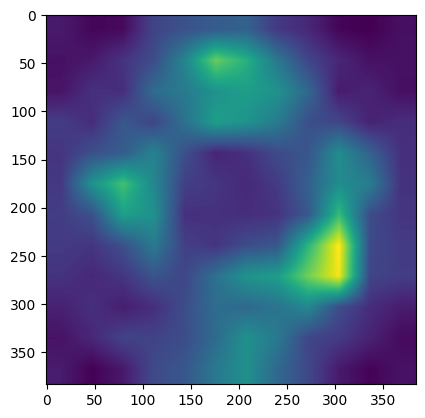

In [24]:
attn = onnx_pred[1][0]
attn = cv.resize(attn, (384,384))
plt.imshow(attn)

# VISUALIZATION

In [ ]:
def plot_sample(x_train,means,logvar,weights):
    cat = tfd.Categorical(probs=weights)
    components = tfd.MultivariateNormalDiag(loc = means,
                        scale_diag = tf.exp(0.5*logvar))

    mog = tfd.MixtureSameFamily(mixture_distribution = cat,
                                components_distribution=components)

    # tf.print(mog.mean())
    # tf.print(tf.reduce_mean(mog.stddev()))
    
    if x_train is not None:
        plt.plot(x_train[:,0], x_train[:,1],'r.')
    x_sample = mog.sample(256)
    tf.print(tf.reduce_mean(x_sample,axis=1))
    tf.print(tf.reduce_mean(x_train,axis=1))
    tf.print(tf.math.reduce_std(x_sample,axis=1))
    tf.print(tf.math.reduce_std(x_train,axis=1))
    plt.plot(x_sample[:,0],x_sample[:,1],'b.')
    plt.axis('equal')
    plt.show()
    return x_sample

In [ ]:
tfd = tfp.distributions
for i,j in train_dataset.take(1):
    # x= resize_rescale_hf(i)
    x = vtadl_model.base_model(i,training=False)
    # x = vtadl_model.act1(x)
    
    # x = vtadl_model.scale_latent_final(x)
    tf.print(x.shape)
    pi, mu, logvar = vtadl_model.gmm(x)
    pi = pi[0,0,...]
    mu = tf.transpose(mu[0,0,...],perm=[0,1])
    logvar = tf.transpose(logvar[0,0,...],perm=[0,1])
    x_train = tf.reshape(x,(-1,256))
    x_sample = plot_sample(x_train, mu, logvar, pi)
    break

In [ ]:
from sklearn.decomposition import PCA

mu_np = np.dot(pi.numpy(),mu.numpy())             # shape [150, 512]
x_train_np = x_train.numpy()   # shape [N, 512], where N is probably 512

# Stack both together for consistent PCA
combined = np.vstack([mu_np, x_train_np])
pca = PCA(n_components=2)
combined_2d = pca.fit_transform(combined)

# Split them back
mu_2d = combined_2d[:mu_np.shape[0]]
x_2d = combined_2d[mu_np.shape[0]:]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c='red', s=10, label='x_train (latent)')
plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c='blue', s=5, label='GMM means (mu)')
plt.title("GMM Component Means vs Latent Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Assuming vtadl_model and test_dataset are defined
for i, j in test_dataset.take(1):
    # x = resize_rescale_hf(i)
    x = vtadl_model.base_model(i)  # (8, 64, 512)
    tf.print(x.shape)  # Should print [8, 64, 512]
    pi, mu, logvar = vtadl_model.gmm(x)  # GMM outputs
    # pi = pi[0,0,...]
    # mu = tf.transpose(mu[0,0,...],perm=[1,0])
    # logvar = tf.transpose(logvar[0,0,...],perm=[1,0])
    x_train = tf.reshape(x, (-1, 512))  # (512, 512)
    break

# Convert to NumPy for plotting
x_sample_np = x_sample.numpy()  # (512, 512)

mu_np = mu.numpy()  # (10, 512)
logvar_np = logvar.numpy()  # (10, 512)
pi_np = pi.numpy()  # (10,)

# Take first 2 dimensions for 2D plotting
x_2d = x_sample_np[:, :2]  # (512, 2)
xtrain_2d = x_train.numpy()[:,:2]
mu_2d = mu_np[:, :2]  # (10, 2)
sigmasq_2d = np.exp(logvar_np[:, :2])  # (10, 2), variances

# Function to plot ellipses
def plot_gaussian_ellipses(mu, sigmasq, ax, n_std=2, **kwargs):
    for i in range(10):  # First 2 components
        center = mu[i]  # (2,)
        width = n_std * np.sqrt(sigmasq[i, 0])  # 2 * std_dev for x-axis
        height = n_std * np.sqrt(sigmasq[i, 1])  # 2 * std_dev for y-axis
        ellipse = Ellipse(xy=center, width=width, height=height, alpha=0.2)
        ax.add_patch(ellipse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_2d[:, 0], x_2d[:, 1], s=5, alpha=0.3, label='Data (first 2 dims)')
plt.scatter(xtrain_2d[:, 0], xtrain_2d[:, 1], s=5, alpha=0.5, label='Data (first 2 dims)')
# Plot ellipses for first 2 components
plot_gaussian_ellipses(mu_2d, sigmasq_2d, plt.gca(), n_std=2, edgecolor='r', facecolor='none', label='Gaussian Components')

plt.title("Data and First 2 Gaussian Components (2D Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
from matplotlib import gridspec
def plot(image, grnd_truth, score):
    fig = plt.figure(figsize=(12, 4))
    spec = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # 3 images + 1 narrow for colorbar

    # Original Image
    ax1 = fig.add_subplot(spec[0])
    ax1.imshow(image)
    ax1.axis('off')

    # Ground Truth
    ax2 = fig.add_subplot(spec[1])
    ax2.imshow(grnd_truth, cmap='gray')
    ax2.axis('off')

    # Predicted Score
    ax3 = fig.add_subplot(spec[2])
    im = ax3.imshow(score, cmap='jet')
    ax3.axis('off')

    # Colorbar in its own column
    cbar_ax = fig.add_subplot(spec[3])
    plt.colorbar(im, cax = cbar_ax, shrink=1.0, fraction=0.04, pad=0.05)

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from scipy.ndimage import gaussian_filter, median_filter

def Patch_Overlap_Score(data, upsample=1):
    norm_loss_t = []
    normalised_score_t = []
    mask_score_t = []
    t_loss_all_normal = []
    t_loss_all_anomaly = []
    visualization = []
    score_visualization = []
    for c, (i, j) in enumerate(data):
        
        loss_grid= vtadl_model(i,training=False)
      
        # mse = tf.keras.losses.MeanSquaredError(reduction='none')(i,res_x)
        # mse = tf.reduce_mean(mse,axis=[2,1])
        # ssim = 1-tf.image.ssim(i,res_x,1.0,filter_size=11)
        # rec_loss = 5*mse + 0.5*ssim
        # # loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        # loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        loss = tf.reduce_max(loss_grid,axis=-1)  # Total loss
        
        mask_score_t += [mask for mask in tf.squeeze(j, axis=[-1]).numpy()]
      
        # loss_grid_max = tf.reduce_max(loss_grid,axis=-1,keepdims=True)
        # loss_grid_min = tf.reduce_min(loss_grid,axis=-1,keepdims=True)
        # loss_grid = (loss_grid - loss_grid_min) / (loss_grid_max - loss_grid_min)
        norm_score = tf.reshape(loss_grid, [-1,12,12])
        norm_score = tf.expand_dims(norm_score,axis=-1)
        score_map = tf.image.resize(norm_score, [IM_SIZE,IM_SIZE], method='bilinear')
        score_map = [gaussian_filter(score.numpy(), sigma=0) for score in tf.squeeze(score_map,axis=-1)]
        normalised_score_t += score_map
        
        #Plotting
        # if c % 1 == 0:
        #     plot(i.numpy()[0], j.numpy()[0], score_map[0])
        visualization.append((i.numpy()[0], j.numpy()[0]))
        score_visualization.append(score_map[0])
        if tf.reduce_mean(j) == 0:
            t_loss_all_normal += loss.numpy().flatten().tolist()
        if tf.reduce_mean(j) != 0:
            t_loss_all_anomaly += loss.numpy().flatten().tolist()
        
    # PRO Score
    unflat_scores = np.asarray(normalised_score_t)
    unflat_masks = np.asarray(mask_score_t)

    scores = np.asarray(normalised_score_t).flatten()
    masks = np.asarray(mask_score_t).flatten()

    for idx in range(len(visualization)):
        # heat_map = score_visualization[idx]
        heat_map = (score_visualization[idx]-np.min(scores))/(np.max(scores)-np.min(scores))
        plot(visualization[idx][0],visualization[idx][1],heat_map)

    PRO_score = roc_auc_score(masks, scores)
  
    # Image Anomaly Classification Score (AUC)
    roc_data = np.concatenate((t_loss_all_normal, t_loss_all_anomaly))
    roc_targets = np.concatenate((np.zeros(len(t_loss_all_normal)), np.ones(len(t_loss_all_anomaly))))
    AUC_Score_total = roc_auc_score(roc_targets, roc_data)
    
    # AUC Precision Recall Curve
    precision, recall, thres = precision_recall_curve(roc_targets, roc_data)
    AUC_PR = auc(recall, precision)
    return PRO_score, AUC_Score_total, AUC_PR, unflat_scores, unflat_masks

In [78]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from scipy.ndimage import gaussian_filter, median_filter

def Patch_Overlap_Score(data, upsample=1):
    norm_loss_t = []
    normalised_score_t = []
    mask_score_t = []
    t_loss_all_normal = []
    t_loss_all_anomaly = []
    visualization = []
    score_visualization = []
    attn_visualization = []
    for c, (i, j) in enumerate(data):
        
        loss_grid, attn_map = vtadl_model(i,training=False)
      
        # mse = tf.keras.losses.MeanSquaredError(reduction='none')(i,res_x)
        # mse = tf.reduce_mean(mse,axis=[2,1])
        # ssim = 1-tf.image.ssim(i,res_x,1.0,filter_size=11)
        # rec_loss = 5*mse + 0.5*ssim
        # # loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        # loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        loss = tf.reduce_max(loss_grid,axis=-1)  # Total loss
        
        mask_score_t += [mask for mask in tf.squeeze(j, axis=[-1]).numpy()]
      
        # loss_grid_max = tf.reduce_max(loss_grid,axis=-1,keepdims=True)
        # loss_grid_min = tf.reduce_min(loss_grid,axis=-1,keepdims=True)
        # loss_grid = (loss_grid - loss_grid_min) / (loss_grid_max - loss_grid_min)
        norm_score = tf.reshape(loss_grid, [-1,12,12])
    
        norm_score = norm_score#*attn_map
        norm_score = tf.expand_dims(norm_score,axis=-1)
        score_map = tf.image.resize(norm_score, [IM_SIZE,IM_SIZE], method='bilinear')
        score_map = [gaussian_filter(score.numpy(), sigma=0) for score in tf.squeeze(score_map,axis=-1)]
        normalised_score_t += score_map
        
        #Plotting
        # if c % 1 == 0:
        #     plot(i.numpy()[0], j.numpy()[0], score_map[0])
        visualization.append((i.numpy()[0], j.numpy()[0]))
        score_visualization.append(score_map[0])
        if tf.reduce_mean(j) == 0:
            t_loss_all_normal += loss.numpy().flatten().tolist()
        if tf.reduce_mean(j) != 0:
            t_loss_all_anomaly += loss.numpy().flatten().tolist()
        
    # PRO Score
    unflat_scores = np.asarray(normalised_score_t)
    unflat_masks = np.asarray(mask_score_t)

    scores = np.asarray(normalised_score_t).flatten()
    masks = np.asarray(mask_score_t).flatten()

    for idx in range(len(visualization)):
        # heat_map = score_visualization[idx]
        heat_map = (score_visualization[idx]-np.min(scores))/(np.max(scores)-np.min(scores))
        plot(visualization[idx][0],visualization[idx][1],heat_map)

    PRO_score = roc_auc_score(masks, scores)
  
    # Image Anomaly Classification Score (AUC)
    roc_data = np.concatenate((t_loss_all_normal, t_loss_all_anomaly))
    roc_targets = np.concatenate((np.zeros(len(t_loss_all_normal)), np.ones(len(t_loss_all_anomaly))))
    AUC_Score_total = roc_auc_score(roc_targets, roc_data)
    
    # AUC Precision Recall Curve
    precision, recall, thres = precision_recall_curve(roc_targets, roc_data)
    AUC_PR = auc(recall, precision)
    return PRO_score, AUC_Score_total, AUC_PR, unflat_scores, unflat_masks

In [ ]:
import pandas as pd
import numpy as np
from skimage import measure
from statistics import mean
from sklearn.metrics import auc

def compute_pro(masks: np.ndarray, amaps: np.ndarray, num_th: int = 200) -> float:
    """Compute the area under the curve of per-region overlapping (PRO) and 0 to 0.3 FPR.

    Args:
        masks (np.ndarray): All binary masks in test. Shape: (num_test_data, h, w).
        amaps (np.ndarray): All anomaly maps in test. Shape: (num_test_data, h, w).
        num_th (int, optional): Number of thresholds. Defaults to 200.

    Returns:
        float: Area under the PRO curve.
    """
    # Input validation
    assert isinstance(amaps, np.ndarray), "amaps must be a numpy ndarray"
    assert isinstance(masks, np.ndarray), "masks must be a numpy ndarray"
    assert amaps.ndim == 3, "amaps must have shape (num_test_data, h, w)"
    assert masks.ndim == 3, "masks must have shape (num_test_data, h, w)"
    assert amaps.shape == masks.shape, "amaps and masks must have the same shape"
    assert set(masks.flatten()) == {0, 1}, "masks must contain only 0 and 1"
    assert isinstance(num_th, int), "num_th must be an integer"

    # Initialize DataFrame
    df = pd.DataFrame(columns=["pro", "fpr", "threshold"], dtype=float)
    binary_amaps = np.zeros_like(amaps, dtype=bool)

    min_th = amaps.min()
    max_th = amaps.max()
    delta = (max_th - min_th) / num_th

    # Thresholding loop
    for th in np.arange(min_th, max_th, delta):
        binary_amaps[:] = amaps > th  # Vectorized thresholding

        pros = []
        for binary_amap, mask in zip(binary_amaps, masks):
            labeled_mask = measure.label(mask)
            regions = measure.regionprops(labeled_mask)
            for region in regions:
                axes0_ids, axes1_ids = region.coords[:, 0], region.coords[:, 1]
                tp_pixels = binary_amap[axes0_ids, axes1_ids].sum()
                pros.append(tp_pixels / region.area)

        # Compute false positive rate
        inverse_masks = 1 - masks
        fp_pixels = np.logical_and(inverse_masks, binary_amaps).sum()
        fpr = fp_pixels / inverse_masks.sum()

        # Append to DataFrame
        new_row = pd.DataFrame({"pro": [mean(pros) if pros else 0], "fpr": [fpr], "threshold": [th]})
        df = pd.concat([df, new_row], ignore_index=True)

    # Normalize FPR to 0–0.3 range
    df = df[df["fpr"] < 0.3].copy()
    if not df.empty and df["fpr"].max() > 0:
        df["fpr"] = df["fpr"] / df["fpr"].max()

    # Compute AUC
    pro_auc = auc(df["fpr"], df["pro"]) if not df.empty else 0.0
    return pro_auc

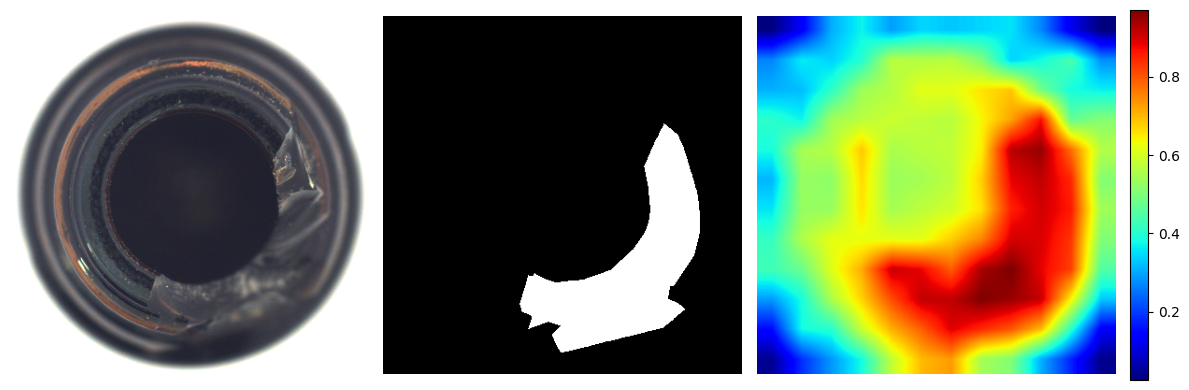

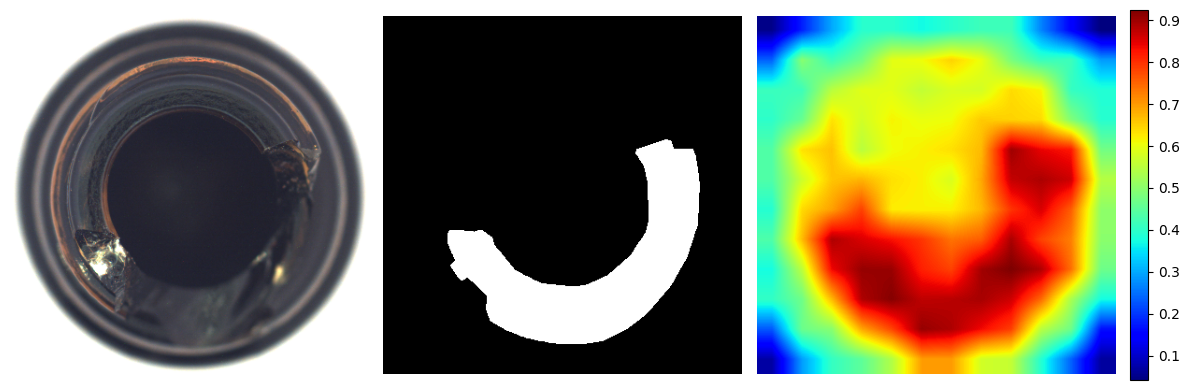

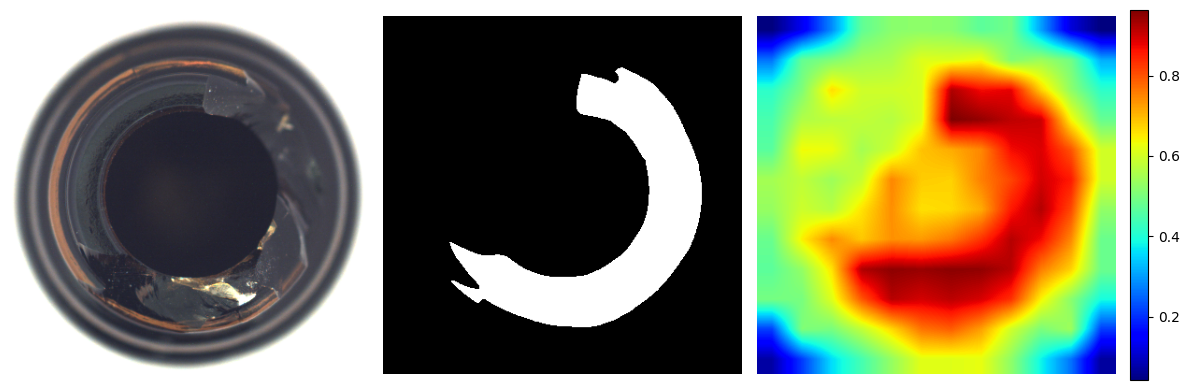

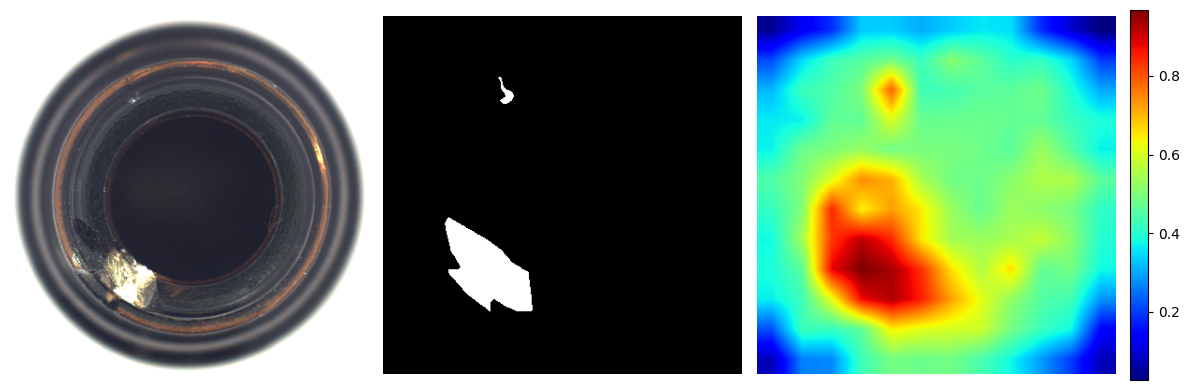

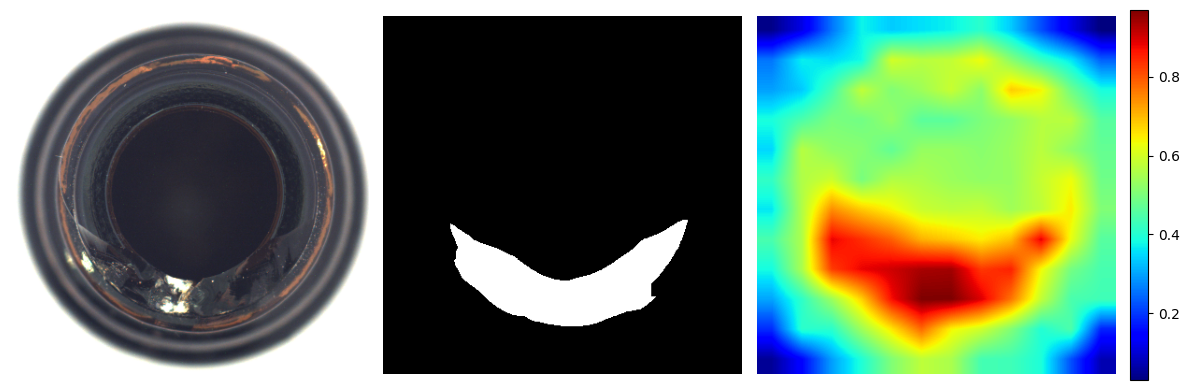

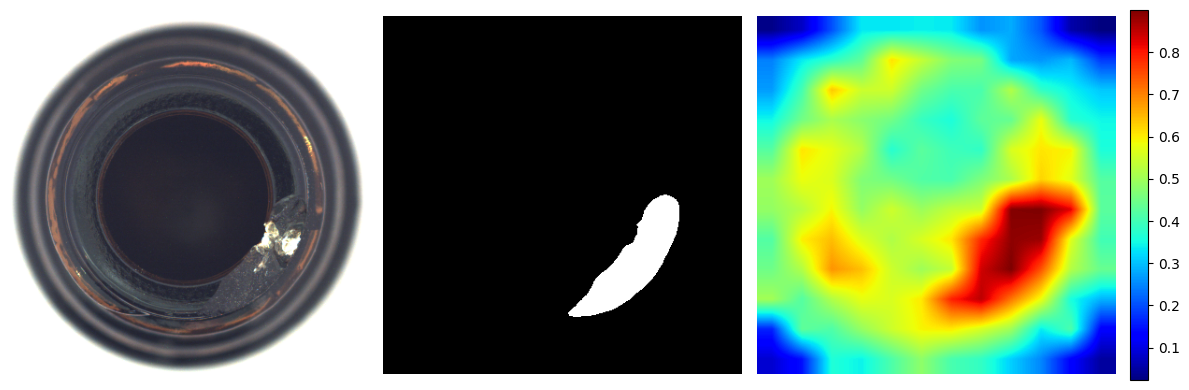

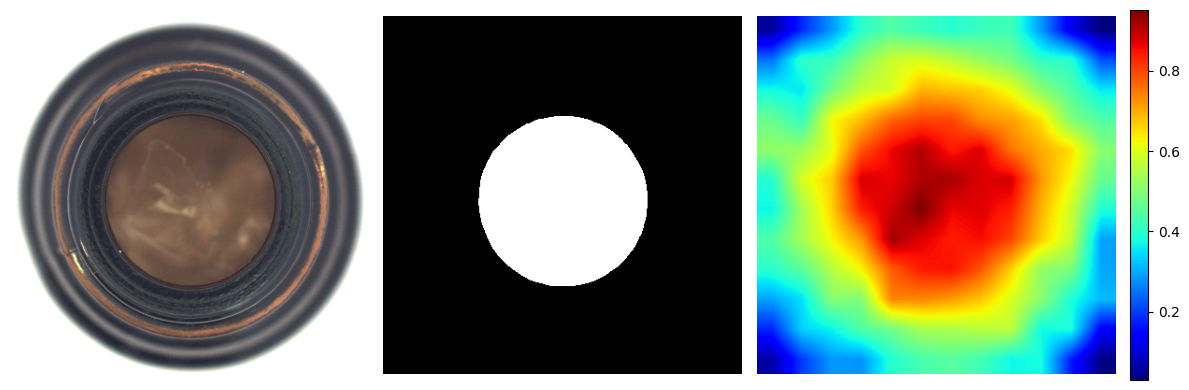

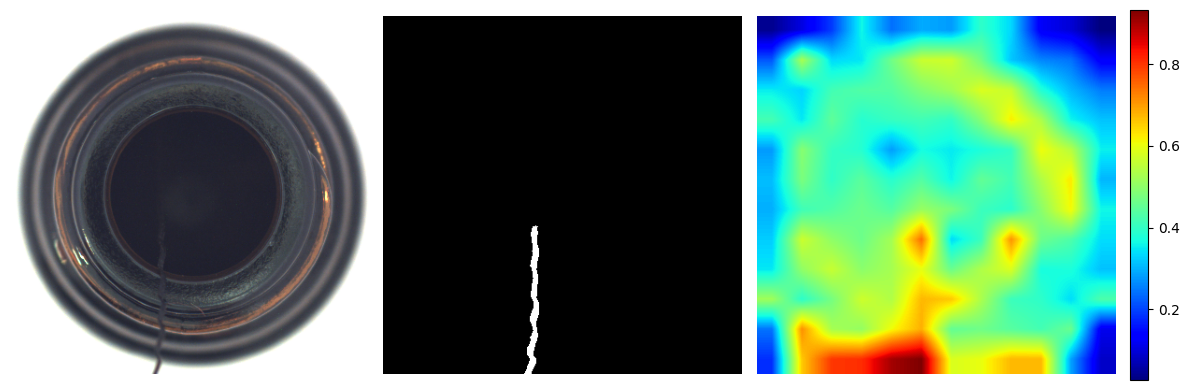

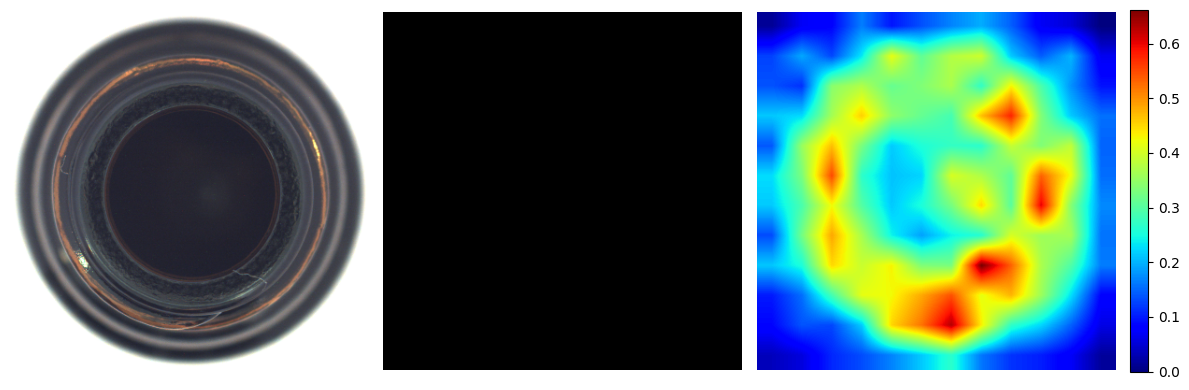

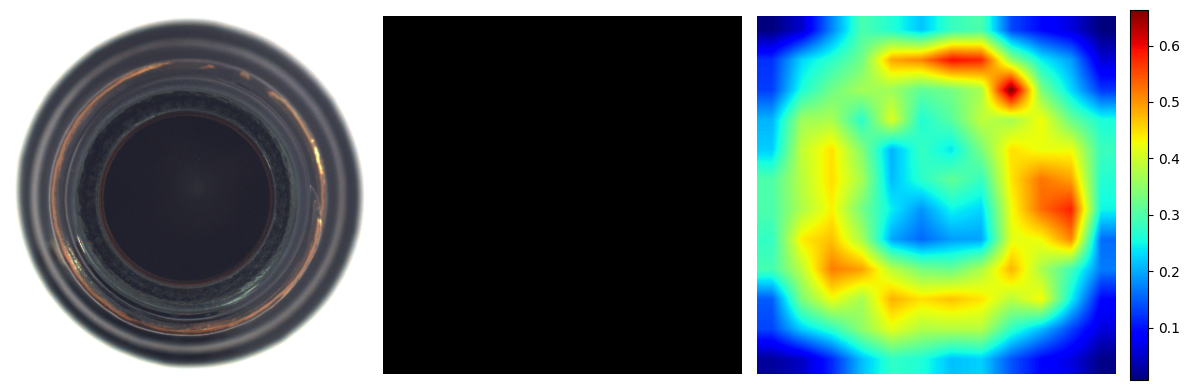

(-0.5, 383.5, 383.5, -0.5)

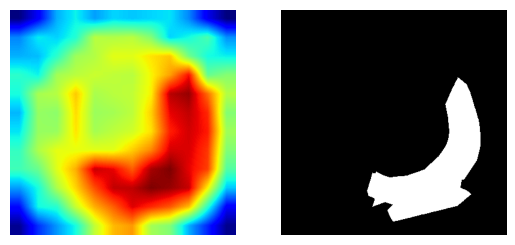

In [153]:
AUROC, AUC, AUC_PR,scores,masks = Patch_Overlap_Score(data=test_dataset)
# scores = (scores-np.min(scores.flatten()))/(np.max(scores.flatten())-np.min(scores.flatten()))

plt.subplot(1,2,1)
plt.imshow(scores[0],cmap='jet')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks[0],cmap='gray')
plt.axis('off')

# PRO = compute_pro(masks,scores)

In [154]:
# print(PRO, AUROC, AUC, AUC_PR)
print(AUROC,AUC, AUC_PR)

0.9773934103208866 0.990234375 0.997767137513919


In [ ]:
0.9773933592362058 0.990234375 0.997767137513919
0.9773933604467789 0.990234375 0.997767137513919
0.9773934103208866 0.990234375 0.997767137513919

In [ ]:
cable need only 10 epochs: 0.8844985605640062 0.9720148048289146 0.9303385416666666 0.9887046688487339
                20 epochs: 0.828658861710289 0.9501158983149266 0.9062499999999999 0.9845412504028647


0.5831904494536843 0.8867916091041164 0.9074074074074074 0.9877947303360158
0.627136438180614 0.8946222429162243 0.9027777777777777 0.9872087157510312

In [ ]:
logs = []
print(logs)

CATEGORIES = ['bottle','cable','capsule','carpet','grid','hazelnut','leather','metal_nut','pill','screw','tile','toothbrush','transistor','wood','zipper']

for i in range(len(CATEGORIES)):
    # create dataset
    tf.print(CATEGORIES[i:i+1])
    base_model = TFViTModel.from_pretrained(pretrained_model_name_or_path ="google/vit-base-patch32-384")
    train_dataset = create_dataset('train', CATEGORIES[i:i+1])
    test_dataset = create_dataset('test', CATEGORIES[i:i+1],False)
    verify_pipeline(train_dataset)

    # initialize model
    vtadl_model = VTADLModel(150,feature_dim=768)
    for k,l in train_dataset.take(1):
        test_input = k
        output = vtadl_model(test_input,training=False)
        tf.print(output[0].shape)

    # train
    vtadl_model.compile()
    vtadl_model.fit(train_dataset, epochs = 15, verbose = 1)

    # evaluate
    AUROC, AUC, AUC_PR,scores,masks = Patch_Overlap_Score(data=test_dataset)
    scores = (scores-np.min(scores.flatten()))/(np.max(scores.flatten())-np.min(scores.flatten()))

    plt.subplot(1,2,1)
    plt.imshow(scores[0],cmap='jet')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(masks[0],cmap='gray')
    plt.axis('off')

    PRO = compute_pro(masks,scores)
    logs.append([CATEGORIES[i], AUROC ,PRO, AUC, AUC_PR])
    tf.print(logs)

In [ ]:
means = np.array([static[2] for static in statics])
means = np.mean(means)
means

In [ ]:
statics = [['bottle',
  0.9495307295196713,
  0.7878492752413248,
  0.990234375,
  0.9976623862403535],
 ['cable',
  0.9517119586695615,
  0.7887401724849976,
  0.9576822916666667,
  0.9934140869279489],
 ['capsule',
  0.9725241067680688,
  0.8164351663122645,
  0.9095982142857143,
  0.9849935304663268],
 ['carpet',
  0.9759744498987216,
  0.8599848855390612,
  0.8971354166666667,
  0.991540124443071],
 ['grid',
  0.8333129545840081,
  0.58183083334365,
  0.599609375,
  0.9370005553986016],
 ['hazelnut',
  0.9774779432843151,
  0.8858599267189255,
  0.9748263888888888,
  0.994718468048102],
 ['leather',
  0.9895944271321037,
  0.9457506777906007,
  0.9811197916666667,
  0.997083333652828],
 ['metal_nut',
  0.9722718781655508,
  0.8595995817957439,
  0.9459635416666666,
  0.9915914612709562],
 ['pill',
  0.9834195467175013,
  0.8903118127323865,
  0.9149305555555555,
  0.9897944558547418],
 ['screw',
  0.9533062998850527,
  0.817268417633569,
  0.5697916666666666,
  0.909992334887695],
 ['tile',
  0.955164777957798,
  0.811027038023124,
  0.9644886363636364,
  0.994291045187273],
 ['toothbrush',
  0.9808954730707052,
  0.7929006969989553,
  0.97265625,
  0.9937948424276549],
 ['transistor',
  0.9296543991633284,
  0.6246130990651315,
  0.9359375,
  0.9713340632008816],
 ['wood',
  0.9610366976708684,
  0.7942994331703881,
  0.9296875,
  0.9912982783035466],
 ['zipper',
  0.8468848101593837,
  0.5744327778076843,
  0.9354166666666668,
  0.9910324030245033]]

In [ ]:
statics= [['bottle',
  0.9818721597628521,
  0.9123172611283017,
  0.9970703125,
  0.9992616431297756],
 ['cable',
  0.9720148048289146,
  0.8844985605640062,
  0.828125,
  0.9670266955937581],
 ['capsule',
  0.9710155152813349,
  0.8337335275232796,
  0.9012276785714286,
  0.9840406584058881],
 ['carpet',
  0.9859630599660546,
  0.9074782597593392,
  0.9309895833333333,
  0.9943680179961205],
 ['grid',
  0.9255413489409943,
  0.7841320735812247,
  0.978515625,
  0.9972974534989562],
 ['hazelnut',
  0.9777838132004375,
  0.9090073598766709,
  0.9713541666666667,
  0.9935848574827268],
 ['leather',
  0.9930746632599107,
  0.9727683147603766,
  0.986328125,
  0.9979388661412609],
 ['metal_nut',
  0.9706217378644536,
  0.9039287100206231,
  0.9505208333333333,
  0.9925154219572575],
 ['pill',
  0.9749678237815171,
  0.9242098759241768,
  0.923611111111111,
  0.9912717106551058],
 ['screw',
  0.9574366471073724,
  0.8462235561474258,
  0.5463541666666666,
  0.9169169510176259],
 ['tile',
  0.967236317817333,
  0.886739491267397,
  0.9794034090909092,
  0.9966008589272051],
 ['toothbrush',
  0.9859644840079176,
  0.8761070497968698,
  0.9765625,
  0.9943336400267584],
 ['transistor',
  0.9431396164997833,
  0.7293449443668907,
  0.7765625,
  0.8907214061003923],
 ['wood', 0.9684968258197112, 0.87829430787973, 0.9453125, 0.9934773798575034],
 ['zipper',
  0.9652363074322805,
  0.8650978983756227,
  0.9947916666666667,
  0.9993278754879018]]

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from scipy.ndimage import gaussian_filter, median_filter

def Patch_Overlap_Score(data, upsample=1):
    norm_loss_t = []
    normalised_score_t = []
    mask_score_t = []
    t_loss_all_normal = []
    t_loss_all_anomaly = []
    visualization = []
    score_visualization = []
    for c, (i, j) in enumerate(data):
        
        loss_grid, res_x,_ = vtadl_model(i,training=False)
    
        mse = tf.keras.losses.MeanSquaredError(reduction='none')(i,res_x)
        mse = tf.reduce_mean(mse,axis=[2,1])
        ssim = 1-tf.image.ssim(i,res_x,1.0,filter_size=11)
        rec_loss = 5*mse + 0.5*ssim
        # loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        loss = rec_loss + tf.reduce_max(loss_grid,axis=-1)  # Total loss
        
        mask_score_t += [mask for mask in tf.squeeze(j, axis=[-1]).numpy()]
      
        # loss_grid_max = tf.reduce_max(loss_grid,axis=-1,keepdims=True)
        # loss_grid_min = tf.reduce_min(loss_grid,axis=-1,keepdims=True)
        # loss_grid = (loss_grid - loss_grid_min) / (loss_grid_max - loss_grid_min)
        norm_score = tf.reshape(loss_grid, [-1,12,12])
        norm_score = tf.expand_dims(norm_score,axis=-1)
        score_map = tf.image.resize(norm_score, [384,384], method='bilinear')
        score_map = [gaussian_filter(score.numpy(), sigma=0) for score in tf.squeeze(score_map,axis=-1)]
        normalised_score_t += score_map
        
        #Plotting
        # if c % 1 == 0:
        #     plot(i.numpy()[0], j.numpy()[0], score_map[0])
        visualization.append((i.numpy()[0], j.numpy()[0]))
        score_visualization.append(score_map[0])
        if tf.reduce_mean(j) == 0:
            t_loss_all_normal += loss.numpy().flatten().tolist()
        if tf.reduce_mean(j) != 0:
            t_loss_all_anomaly += loss.numpy().flatten().tolist()
        
    # PRO Score
    scores = np.asarray(normalised_score_t).flatten()
    masks = np.asarray(mask_score_t).flatten()

    for idx in range(len(visualization)):
        heat_map = (score_visualization[idx]-np.min(scores))/(np.max(scores)-np.min(scores))
        plot(visualization[idx][0],visualization[idx][1],heat_map)

    
    PRO_score = roc_auc_score(masks, scores)
  
    # Image Anomaly Classification Score (AUC)
    roc_data = np.concatenate((t_loss_all_normal, t_loss_all_anomaly))
    roc_targets = np.concatenate((np.zeros(len(t_loss_all_normal)), np.ones(len(t_loss_all_anomaly))))
    AUC_Score_total = roc_auc_score(roc_targets, roc_data)
    
    # AUC Precision Recall Curve
    precision, recall, thres = precision_recall_curve(roc_targets, roc_data)
    AUC_PR = auc(recall, precision)
    return PRO_score, AUC_Score_total, AUC_PR

In [ ]:
# bottle 0.9743625331181789 0.9917763157894737 0.9978141743194853
# cable
# capsule   0.966279311214141 0.8991596638655462 0.9827562380690824
# carpet    0.9889375389210118 0.9479166666666666 0.9934755889771373
# grid      0.9133130065603858 0.8413461538461537 0.9676785828143122
# hazelnut  0.9837066287169705 0.9907407407407407 0.9978560194702839
# leather   0.9920564514488606 0.9817708333333334 0.9972781778079556
# metal_nut 0.9689790918278909 0.9705882352941176 0.995245297926611
# pill      0.9742158410800088 0.9526143790849673 0.9945473286163724
# screw     0.9769773547468795 0.6947368421052631 0.8947962934110745
# tile      0.9592263820662444 0.9680397727272727 0.994784419461336
# tooth_brush 0.9846393512815113 0.959375 0.98883629491121
# transistor  0.9197332601031005 0.91 0.9599480468899149
# wood        0.9657017983240996 0.9291666666666666 0.9846430451405712
# zipper      0.8844698905393676 0.9232456140350876 0.9874272787612837
# gfc-81:     0.8855387607555792 0.8873456790123456 0.9834455793580589

In [ ]:
normal_scores = []
for i,j in train_dataset:
    loss_grid, res_x,_ = vtadl_model(i)
    normal_scores.append(loss_grid.numpy())

normal_scores = np.array(normal_scores)
normal_scores= normal_scores.reshape(-1,144)
normal_scores = np.mean(normal_scores,axis=0)
normal_scores = normal_scores.reshape(12,12)
normal_scores.shape

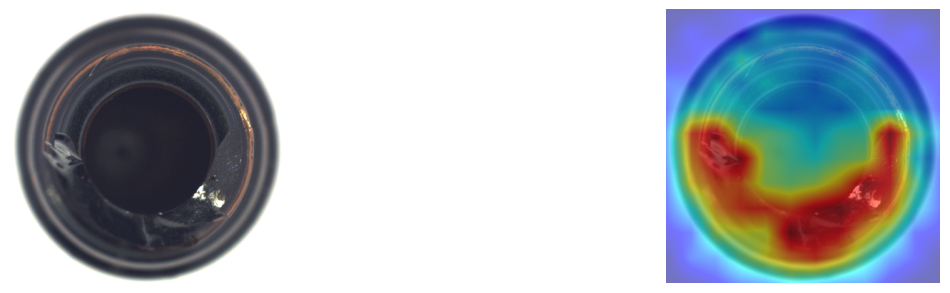

In [13]:
import cv2 as cv
from scipy.ndimage import zoom, gaussian_filter

plt.figure(figsize=(12,12))
# test_img = load_and_preprocess('/kaggle/input/cable/test/combined/001.png')  # Returns RGB Tensor
# for i, j in test_dataset.skip(3):
#     k= 7
#     test_img = i[k]
#     j=j[k].numpy()
#     break
# loss_grid, attn = vtadl_model(tf.expand_dims(test_img, axis=0),training= False)
loss_grid, attn = onnx_pred[0], [1]
plt.subplot(1, 3, 1)
plt.imshow(test_img)  # RGB, no conversion needed
# plt.imshow(attn.numpy()[0])  # RGB, no conversion needed
plt.axis('off')

loss_grid = tf.reshape(loss_grid, (12, 12))

loss_grid = loss_grid * attn[0]

loss_grid = (loss_grid- np.min(loss_grid))/(np.max(loss_grid)-np.min(loss_grid))

gamma = 2.0
loss_grid = (1- tf.exp(-loss_grid)) ** gamma * loss_grid

# loss_grid = tf.reshape(tf.abs((loss_grid[0]-1*loss)), (8, 8))
# print("Loss grid:\n", loss_grid)

# print(tf.image.ssim(test_img,res_x,1.0,11))
# print(tf.image.psnr(test_img,res_x,1.0))

heatmap = zoom((loss_grid), (32,32), order=1)
heatmap = gaussian_filter(heatmap,sigma=0.0)
heatmap_norm = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-12)

heatmap_uint8 = (heatmap_norm * 255).astype(np.uint8)
heatmap_colored = cv.applyColorMap(heatmap_uint8, cv.COLORMAP_JET)
# heatmap_colored = cv.GaussianBlur(heatmap_colored, (5,5), 0.0)
# heatmap_colored = np.where(heatmap_uint8[...,None] < np.percentile(heatmap_colored,5), np.array([255, 0, 0], dtype=np.uint8) ,heatmap_colored,)

test_img_uint8 = (test_img.numpy() * 255).astype(np.uint8)  # RGB, [0, 255]
test_img_bgr = cv.cvtColor(test_img_uint8, cv.COLOR_RGB2BGR)
overlay = cv.addWeighted(test_img_bgr, 0.45, heatmap_colored, 0.55, 0)
overlay_rgb = cv.cvtColor(overlay, cv.COLOR_BGR2RGB)

# plt.subplot(1, 3, 2)
# plt.imshow(j,cmap='gray')
# plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(overlay_rgb)
plt.axis("off")


# plt.subplot(1, 3, 3)
# plt.imshow(res_x.numpy()[0])
# plt.axis("off")

plt.savefig('with_attn_reweighting.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
x = np.linspace(0, 1)
# Step 2: Define the transformation function
gamma = 3.0
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
transformed = (1 - tf.exp(-x_tf)) ** gamma * x_tf

# Step 3: Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, transformed.numpy(), marker='o', label=r'$(1 - e^{-x})^\gamma \cdot x$')
plt.title('Transformed Function Shape with $\gamma = 3.0$')
plt.xlabel('Input (x)')
plt.ylabel('Transformed Output')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(24,24))

test_img = cv2.imread('/kaggle/input/train-dataset/sample/data/D300MN1292X165Y108X288Y217.bmp')/255.
def brightness_equalization(image, brightness_threshold=0.1, compression_strength=1.0):
 
    brightness = tf.reduce_max(image, axis=-1, keepdims=True)  # Shape: (H, W, 1)
    
    scaling_factor = 1.0 / (1.0 + tf.exp(compression_strength * (brightness - brightness_threshold)))
    
    equalized_image = image * scaling_factor  # Shape: (H, W, 3)
    
    equalized_image = tf.clip_by_value(equalized_image, 0.0, 1.0)
    
    return equalized_image

test_img = tf.expand_dims(tf.convert_to_tensor(test_img),axis=0)
# test_img = tf.image.image_gradients(
#     tf.expand_dims(test_img,axis=0)
# )
plt.subplot(1,3,1)
plt.imshow(test_img[0])

equalized_img = brightness_equalization(
    test_img,
    brightness_threshold=0.45*tf.reduce_max(test_img),  # Target pixels above 0.9
    compression_strength=0.5  # Moderate compression
)
equalized_img = (equalized_img[0].numpy()*255).astype('uint8')

_,equalized_img = cv2.threshold(equalized_img[...,0], 120, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
plt.subplot(1,3,2)
plt.imshow(equalized_img)

                                
equalized_img = np.expand_dims(equalized_img,axis=-1)
equalized_img = np.concatenate((equalized_img,equalized_img,equalized_img),axis=-1)
equalized_img,coord = imread_center(equalized_img)
print(coord)

test_img = test_img[0].numpy()[coord[1]:coord[-1],coord[0]:coord[-2]]
test_img = cv2.resize(test_img,(384,384))
plt.subplot(1,3,3)
plt.imshow(test_img)


In [ ]:
Result = color_loss(test_img, res_x[0])
# tf.print(tf.reduce_min(Result),tf.reduce_max(Result))
# low_threshold = 0.0001  # Example: Remove losses below 0.01
# high_threshold = 0.0001  # Example: Remove losses above 0.1

# Result_masked = tf.where(
#     tf.math.greater(high_threshold,Result),Result,0)

# Result_masked = Result_masked.numpy()

plt.imshow(Result)

In [ ]:
import cv2 as cv
from scipy.ndimage import zoom, gaussian_filter

plt.figure(figsize=(24,24))
# test_img = load_and_preprocess('/kaggle/input/mvtec-ad/bottle/test/broken_large/003.png')  # Returns RGB Tensor
# test_img = load_and_preprocess('/kaggle/input/mvtec-ad/capsule/test/squeeze/004.png')  # Returns RGB Tensor
test_img = load_and_preprocess('/kaggle/input/cable/test/cable_swap/003.png')  # Returns RGB Tensor
# test_img = load_and_preprocess('/kaggle/input/mvtec-ad/hazelnut/test/crack/001.png')  # Returns RGB Tensor
# test_img = sharpen_image(test_img)
# test_img = process_image(test_img)
plt.subplot(1, 3, 1)
plt.imshow(test_img.numpy())  # RGB, no conversion needed
plt.axis('off')
loss_grid, res_x, _  = vtadl_model(tf.expand_dims(test_img, axis=0),training= False)
# loss_grid = tf.reshape(loss_grid, (12, 12))
# loss_grid = tf.abs(test_img-res_x)
loss_grid = 1-tf.image.ssim(test_img,res_x,1.0,31,return_index_map=True)
tf.print(loss_grid.shape)
# loss_grid = tf.reshape(tf.abs((loss_grid[0]-1*loss)), (8, 8))
# print("Loss grid:\n", loss_grid)

print(tf.image.ssim(test_img,res_x,1.0,11))
print(tf.image.psnr(test_img,res_x,1.0))
# heatmap = zoom((loss_grid-1*normal_scores), (32, 32), order=1)
# heatmap = zoom((loss_grid), (32,32), order=3)
heatmap= loss_grid.numpy()[0]

heatmap = cv.resize(heatmap,(384,384))

heatmap_norm = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-12)


heatmap_uint8 = (heatmap_norm * 255).astype(np.uint8)
heatmap_colored = heatmap_uint8

heatmap_colored = cv.applyColorMap(heatmap_uint8, cv.COLORMAP_JET)
heatmap_colored = cv.GaussianBlur(heatmap_colored, (5,5), 0.0)
# heatmap_colored = np.where(heatmap_uint8[...,None] < np.percentile(heatmap_colored,5), np.array([255, 0, 0], dtype=np.uint8) ,heatmap_colored,)

test_img_uint8 = (test_img.numpy() * 255).astype(np.uint8)  # RGB, [0, 255]
test_img_bgr = cv.cvtColor(test_img_uint8, cv.COLOR_RGB2BGR)
overlay = cv.addWeighted(test_img_bgr, 0.45, heatmap_colored, 0.55, 0)
overlay_rgb = cv.cvtColor(overlay, cv.COLOR_BGR2RGB)

plt.subplot(1, 3, 2)
plt.imshow(overlay_rgb)
plt.axis("off")
plt.title("Loss Heatmap Overlay")

plt.subplot(1, 3, 3)
plt.imshow(res_x.numpy()[0])
plt.axis("off")

plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Full latent space

for i,j in train_dataset.take(1):
    # x = Permute((3,1,2))(i)
    x = vtadl_model.base_model(i)
    # loss_grid, res_x,features  = vtadl_model(i,training= False)
    loss_grid  = vtadl_model(i,training= False)
    loss_grid = loss_grid[0]
    # tf.print(loss_grid.shape)
    # plt.contour(x[..., 0], x[..., 1], loss_grid);
    
    x_np = x.numpy()  
    x_reshaped = x_np.reshape(-1, 256)
    pca = PCA(n_components=5)
    x_pca = pca.fit_transform(x_reshaped)  # Shape: (512, 2)
    x_reshaped= x_pca
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(x_reshaped)
    silhouette = silhouette_score(x_reshaped, labels)
    print("Silhouette Score (512D):", silhouette)
    
    loss_grid_np = loss_grid.numpy()
    loss_grid_np = (loss_grid_np-loss_grid_np.min())/(loss_grid_np.max()-loss_grid_np.min())
    
    loss_grid_np = np.round(loss_grid_np).flatten()
  
    # Apply PCA to reduce to 2D

    # Plot the PCA results
    plt.figure(figsize=(8, 6))
    for i in range(2):
        plt.scatter(x_pca[loss_grid_np == i, 0], x_pca[loss_grid_np == i,1], label=f'Sample {i}')
    plt.legend()
    plt.title('PCA Visualization of Latent Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    break

In [ ]:
!pip install umap-learn

In [ ]:
import umap
for i,j in test_dataset.skip(1):
    features = vtadl_model.base_model(i)
features = tf.reshape(features,(-1,256))

# Initialize UMAP
reducer = umap.UMAP(
    n_components=2,  # Reduce to 2D for visualization
    n_neighbors=8,  # Controls local vs. global structure (default: 15)
    min_dist=0.1,    # Minimum distance between points in low-D space (default: 0.1)
    metric='cosine', # Good for high-dimensional embeddings (alternatives: 'euclidean')
    random_state=42  # For reproducibility
)

# # Fit and transform
embedding = reducer.fit_transform(features)  # Shape: (1152, 2)
print("UMAP embedding shape:", embedding.shape)  # (1152, 2)

In [ ]:
# image_labels = np.repeat(np.arange(8), 144)  # [0, 0,..., 1, 1, ..., 7, 7]
image_labels = np.tile(np.arange(144), 8)  # [0, 0, ..., 1, 1, ..., 7, 7]

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    
    embedding[:, 1],
    c=image_labels,
    cmap='viridis',
    s=20,
    alpha=0.6
)

# for i in range(len(embedding[0:144])):
#     # Adjust label to start from 1 instead of 0
#     label = image_labels[i]
#     plt.text(
#         embedding[i, 0], 
#         embedding[i, 1], 
#         str(label),
#         fontsize=10,
#         ha='center',
#         va='center',
#         alpha=0.7
#     )

plt.colorbar(scatter, label='Image Index')
plt.title("UMAP Projection of ViT Patch Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [ ]:
# !git clone https://github.com/pankajmishra000/VT-ADL.git

In [ ]:
# cd VT-ADL

In [ ]:
# # %load mvtech.py
# """
# @author: Pankaj Mishra
# """
# import torch
# from torchvision import transforms
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from skimage.io import imread
# from collections import OrderedDict
# from itertools import chain
# import random
# random.seed(123)

# def read_files(root,d, product, data_motive = 'train', use_good = True, normal = True):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         d = List of directories in the root directory
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         data_motve : Can be 'train' or 'test' based on the intention of the data loader function
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
#         normal : Signofy if the normal imgaes are included while loading or not. Accepts boolean value  True or False
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     files = next(os.walk(os.path.join(root,d)))[1]
#         #    print(files)
#     for d_in in files:
#         if os.path.isdir(os.path.join(root,d,d_in)):
#             if d_in == data_motive :
#                 im_pt = OrderedDict()
#                 file = os.listdir(os.path.join(root,d, d_in))
                
#                 for i in file:
#                     if os.path.isdir(os.path.join(root, d, d_in,i)):
#                         if (data_motive == 'train'):
#                             tr_img_pth = os.path.join(root, d, d_in,i)
#                             images = os.listdir(tr_img_pth)
#                             im_pt[tr_img_pth] = images
#                             print(f'total {d_in} images of {i} {d} are: {len(images)}')
                            
#                         if (data_motive == 'test') :
#                             if (use_good == False) and (i == 'good') and normal != True:
#                                 print(f'the good images for {d_in} images of {i} {d} is not included in the test anomolous data')
#                             elif (use_good == False) and (i != 'good') and normal != True :
#                                 tr_img_pth = os.path.join(root, d, d_in,i)
#                                 images = os.listdir(tr_img_pth)
#                                 im_pt[tr_img_pth] = images
#                                 print(f'total {d_in} images of {i} {d} are: {len(images)}')
#                             elif (use_good == True) and (i == 'good') and (normal== True):
#                                 tr_img_pth = os.path.join(root, d, d_in,i)
#                                 images = os.listdir(tr_img_pth)
#                                 im_pt[tr_img_pth] = images
#                                 print(f'total {d_in} images of {i} {d} are: {len(images)}') 
#                         if (data_motive == 'ground_truth'):
#                             tr_img_pth = os.path.join(root, d, d_in,i)
#                             images = os.listdir(tr_img_pth)
#                             im_pt[tr_img_pth] = images
#                             print(f'total {d_in} images of {i} {d} are: {len(images)}')
#                 if product == "all":
#                     return
#                 else:
#                     return im_pt #tr_img_pth, images
                    
# def load_images(path, image_name):
#     return imread(os.path.join(path,image_name))

    
# def Test_anom_data(root, product= 'bottle', use_good = False):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product, data_motive = 'test',use_good = use_good,normal = False)
            
#         elif product == d:
#             pth_img_dict= read_files(root, d, product,data_motive='test', use_good = use_good, normal = False)
#             return pth_img_dict
        
# def Test_anom_mask(root, product= 'bottle', use_good = False):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product, data_motive = 'test',use_good = use_good,normal = False)
            
#         elif product == d:
#             pth_img_dict= read_files(root, d, product,data_motive='ground_truth', use_good = use_good, normal = False)
#             return pth_img_dict
        

# def Test_normal_data(root, product= 'bottle', use_good = True):
#     if product == 'all':
#         print('Please choose a valid product. Normal test data can be seen product wise')
#         return
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == d:
#             pth_img = read_files(root, d, product,data_motive='test',use_good = True, normal = True)
#             return pth_img
    
                      
# def Train_data(root, product = 'bottle', use_good = True):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is True as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the training dataset
#     '''
    
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product,data_motive='train')            

#         elif product == d:
#             pth_img = read_files(root, d, product,data_motive='train')
#             return pth_img
        
# def Process_mask(mask):
#     mask = np.where(mask > 0., 1, mask)
#     return torch.tensor(mask)

# def ran_generator(length, shots=1):
#     rand_list = random.sample(range(0,length), shots)
#     return rand_list
        
        
# class Mvtec:
#     def __init__(self, batch_size,root="/kaggle/input/mvtec-ad/", product= 'bottle'):
#         self.root = root
#         self.batch = batch_size
#         self.product = product
#         torch.manual_seed(123)
#         if self.product == 'all':
#             print('--------Please select a valid product.......See Train_data function-----------')
#         else:
#          # Importing all the image_path dictionaries for  test and train data #
#             train_path_images =Train_data(root = self.root, product = self.product)
#             test_anom_path_images = Test_anom_data(root = self.root, product=self.product)
#             test_anom_mask_path_images = Test_anom_mask(root = self.root, product = self.product)
#             test_norm_path_images = Test_normal_data(root= self.root, product = self.product)
            
#             ## Image Transformation ##
#             T = transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.Resize((550,550)),
#                 transforms.CenterCrop(512),
#                 transforms.ToTensor(),
#     #            transforms.Normalize((0.1307,), (0.3081,)),
#             ])
#             train_normal_image = torch.stack([T(load_images(j,i)) for j in train_path_images.keys() for i in train_path_images[j]])
#             test_anom_image = torch.stack([T(load_images(j,i)) for j in test_anom_path_images.keys() for i in test_anom_path_images[j]])
#             test_normal_image = torch.stack([T(load_images(j,i)) for j in test_norm_path_images.keys() for i in test_norm_path_images[j]])
            
#             train_normal_mask = torch.zeros(train_normal_image.size(0), 1,train_normal_image.size(2), train_normal_image.size(3)  )
#             test_normal_mask = torch.zeros(test_normal_image.size(0), 1,test_normal_image.size(2), test_normal_image.size(3)  )
#             test_anom_mask = torch.stack([Process_mask(T(load_images(j,i))) for j in test_anom_mask_path_images.keys() for i in test_anom_mask_path_images[j]])
            
#             train_normal = tuple(zip(train_normal_image, train_normal_mask))
#             test_anom = tuple(zip(test_anom_image, test_anom_mask))
#             test_normal = tuple(zip(test_normal_image,test_normal_mask))                      
#             print(f' --Size of {self.product} train loader: {train_normal_image.size()}--')
#             if test_anom_image.size(0) ==test_anom_mask.size(0):
#                 print(f' --Size of {self.product} test anomaly loader: {test_anom_image.size()}--')
#             else:
#                 print(f'[!Info] Size Mismatch between Anomaly images {test_anom_image.size()} and Masks {test_anom_mask.size()} Loaded')
#             print(f' --Size of {self.product} test normal loader: {test_normal_image.size()}--')          
            
#             # validation set #
#             num = ran_generator(len(test_anom),10)
#             val_anom = [test_anom[i] for i in num]
#             num = ran_generator(len(test_normal),10)
#             val_norm = [test_normal[j] for j in num]
#             val_set = [*val_norm, *val_anom]
#             print(f' --Total Image in {self.product} Validation loader: {len(val_set)}--')
#             ####  Final Data Loader ####
#             self.train_loader  = torch.utils.data.DataLoader(train_normal, batch_size=batch_size, shuffle=True)            
#             self.test_anom_loader = torch.utils.data.DataLoader(test_anom, batch_size = batch_size, shuffle=False)
#             self.test_norm_loader = torch.utils.data.DataLoader(test_normal, batch_size=batch_size, shuffle=False)
#             self.validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
        
            
            
# if __name__ == "__main__":
    
#     root = "D:\\second year\\mvtec_anomaly_detection"
#     # print('======== All Normal Data ============')
#     # Train_data(root, 'all')
#     # print('======== All Anomaly Data ============')
#     # Test_anom_data(root,'all')    
          
#     train = Mvtec(1,root,'bottle')
#     for i, j in train.test_anom_loader:
#         print(i.shape)
#         plt.imshow(i.squeeze(0).permute(1,2,0))
#         plt.show
#         break
    
        
                           
                            
                


In [ ]:
# with open("./mvtec.py", "w") as file:
#     file.write(script)

In [ ]:
# %%writefile mvtech.py  
# # %load mvtech.py
# """
# @author: Pankaj Mishra
# """
# import torch
# from torchvision import transforms
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from skimage.io import imread
# from collections import OrderedDict
# from itertools import chain
# import random
# random.seed(123)

# def read_files(root,d, product, data_motive = 'train', use_good = True, normal = True):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         d = List of directories in the root directory
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         data_motve : Can be 'train' or 'test' based on the intention of the data loader function
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
#         normal : Signofy if the normal imgaes are included while loading or not. Accepts boolean value  True or False
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     files = next(os.walk(os.path.join(root,d)))[1]
#         #    print(files)
#     for d_in in files:
#         if os.path.isdir(os.path.join(root,d,d_in)):
#             if d_in == data_motive :
#                 im_pt = OrderedDict()
#                 file = os.listdir(os.path.join(root,d, d_in))
                
#                 for i in file:
#                     if os.path.isdir(os.path.join(root, d, d_in,i)):
#                         if (data_motive == 'train'):
#                             tr_img_pth = os.path.join(root, d, d_in,i)
#                             images = os.listdir(tr_img_pth)
#                             im_pt[tr_img_pth] = images
#                             print(f'total {d_in} images of {i} {d} are: {len(images)}')
                            
#                         if (data_motive == 'test') :
#                             if (use_good == False) and (i == 'good') and normal != True:
#                                 print(f'the good images for {d_in} images of {i} {d} is not included in the test anomolous data')
#                             elif (use_good == False) and (i != 'good') and normal != True :
#                                 tr_img_pth = os.path.join(root, d, d_in,i)
#                                 images = os.listdir(tr_img_pth)
#                                 im_pt[tr_img_pth] = images
#                                 print(f'total {d_in} images of {i} {d} are: {len(images)}')
#                             elif (use_good == True) and (i == 'good') and (normal== True):
#                                 tr_img_pth = os.path.join(root, d, d_in,i)
#                                 images = os.listdir(tr_img_pth)
#                                 im_pt[tr_img_pth] = images
#                                 print(f'total {d_in} images of {i} {d} are: {len(images)}') 
#                         if (data_motive == 'ground_truth'):
#                             tr_img_pth = os.path.join(root, d, d_in,i)
#                             images = os.listdir(tr_img_pth)
#                             im_pt[tr_img_pth] = images
#                             print(f'total {d_in} images of {i} {d} are: {len(images)}')
#                 if product == "all":
#                     return
#                 else:
#                     return im_pt #tr_img_pth, images
                    
# def load_images(path, image_name):
#     return imread(os.path.join(path,image_name))

    
# def Test_anom_data(root, product= 'bottle', use_good = False):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product, data_motive = 'test',use_good = use_good,normal = False)
            
#         elif product == d:
#             pth_img_dict= read_files(root, d, product,data_motive='test', use_good = use_good, normal = False)
#             return pth_img_dict
        
# def Test_anom_mask(root, product= 'bottle', use_good = False):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is False as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the test dataset
#     '''
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product, data_motive = 'test',use_good = use_good,normal = False)
            
#         elif product == d:
#             pth_img_dict= read_files(root, d, product,data_motive='ground_truth', use_good = use_good, normal = False)
#             return pth_img_dict
        

# def Test_normal_data(root, product= 'bottle', use_good = True):
#     if product == 'all':
#         print('Please choose a valid product. Normal test data can be seen product wise')
#         return
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == d:
#             pth_img = read_files(root, d, product,data_motive='test',use_good = True, normal = True)
#             return pth_img
    
                      
# def Train_data(root, product = 'bottle', use_good = True):
#     '''
#     return the path of the train directory and list of train images
    
#     Parameters:
#         root : root directory of mvtech images
#         product : name of the product to return the images for single class training.Products are-
#             ['all','bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 
#             'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
#         use_good : To use the data in the good folder. For training the default is True as we need the data of good folder.
        
#     Returns:
#         Path and Image ordered dict for the training dataset
#     '''
    
#     dir = os.listdir(root)
    
#     for d in dir:
#         if product == "all":
#             read_files(root, d, product,data_motive='train')            

#         elif product == d:
#             pth_img = read_files(root, d, product,data_motive='train')
#             return pth_img
        
# def Process_mask(mask):
#     mask = np.where(mask > 0., 1, mask)
#     return torch.tensor(mask)

# def ran_generator(length, shots=1):
#     rand_list = random.sample(range(0,length), shots)
#     return rand_list
        
        
# class Mvtec:
#     def __init__(self, batch_size,root="/kaggle/input/mvtec-ad/", product= 'bottle'):
#         self.root = root
#         self.batch = batch_size
#         self.product = product
#         torch.manual_seed(123)
#         if self.product == 'all':
#             print('--------Please select a valid product.......See Train_data function-----------')
#         else:
#          # Importing all the image_path dictionaries for  test and train data #
#             train_path_images =Train_data(root = self.root, product = self.product)
#             test_anom_path_images = Test_anom_data(root = self.root, product=self.product)
#             test_anom_mask_path_images = Test_anom_mask(root = self.root, product = self.product)
#             test_norm_path_images = Test_normal_data(root= self.root, product = self.product)
            
#             ## Image Transformation ##
#             T = transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.Resize((550,550)),
#                 transforms.CenterCrop(512),
#                 transforms.ToTensor(),
#     #            transforms.Normalize((0.1307,), (0.3081,)),
#             ])
#             train_normal_image = torch.stack([T(load_images(j,i)) for j in train_path_images.keys() for i in train_path_images[j]])
#             test_anom_image = torch.stack([T(load_images(j,i)) for j in test_anom_path_images.keys() for i in test_anom_path_images[j]])
#             test_normal_image = torch.stack([T(load_images(j,i)) for j in test_norm_path_images.keys() for i in test_norm_path_images[j]])
            
#             train_normal_mask = torch.zeros(train_normal_image.size(0), 1,train_normal_image.size(2), train_normal_image.size(3)  )
#             test_normal_mask = torch.zeros(test_normal_image.size(0), 1,test_normal_image.size(2), test_normal_image.size(3)  )
#             test_anom_mask = torch.stack([Process_mask(T(load_images(j,i))) for j in test_anom_mask_path_images.keys() for i in test_anom_mask_path_images[j]])
            
#             train_normal = tuple(zip(train_normal_image, train_normal_mask))
#             test_anom = tuple(zip(test_anom_image, test_anom_mask))
#             test_normal = tuple(zip(test_normal_image,test_normal_mask))                      
#             print(f' --Size of {self.product} train loader: {train_normal_image.size()}--')
#             if test_anom_image.size(0) ==test_anom_mask.size(0):
#                 print(f' --Size of {self.product} test anomaly loader: {test_anom_image.size()}--')
#             else:
#                 print(f'[!Info] Size Mismatch between Anomaly images {test_anom_image.size()} and Masks {test_anom_mask.size()} Loaded')
#             print(f' --Size of {self.product} test normal loader: {test_normal_image.size()}--')          
            
#             # validation set #
#             num = ran_generator(len(test_anom),10)
#             val_anom = [test_anom[i] for i in num]
#             num = ran_generator(len(test_normal),10)
#             val_norm = [test_normal[j] for j in num]
#             val_set = [*val_norm, *val_anom]
#             print(f' --Total Image in {self.product} Validation loader: {len(val_set)}--')
#             ####  Final Data Loader ####
#             self.train_loader  = torch.utils.data.DataLoader(train_normal, batch_size=batch_size, shuffle=True)            
#             self.test_anom_loader = torch.utils.data.DataLoader(test_anom, batch_size = batch_size, shuffle=False)
#             self.test_norm_loader = torch.utils.data.DataLoader(test_normal, batch_size=batch_size, shuffle=False)
#             self.validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
        
            
            
# if __name__ == "__main__":
    
#     root = "D:\\second year\\mvtec_anomaly_detection"
#     # print('======== All Normal Data ============')
#     # Train_data(root, 'all')
#     # print('======== All Anomaly Data ============')
#     # Test_anom_data(root,'all')    
          
#     train = Mvtec(1,root,'bottle')
#     for i, j in train.test_anom_loader:
#         print(i.shape)
#         plt.imshow(i.squeeze(0).permute(1,2,0))
#         plt.show
#         break
    
        
                           
                 

In [ ]:
# %%writefile train.py
# # %load train.py

# import torch
# import mvtech
# import torchvision.utils as utils
# import matplotlib.pyplot as plt
# from torch.optim import Adam
# import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
# import os
# import numpy as np
# import pytorch_ssim
# import mdn1
# from VT_AE import VT_AE as ae
# import argparse

# ## Argparse declaration ##

# ap = argparse.ArgumentParser()
# ap.add_argument("-p", "--product", required=True,default = 'hazelnut',help="product from the dataset MvTec or BTAD")
# ap.add_argument("-e", "--epochs", required=False, default= 400, help="Number of epochs to train")
# ap.add_argument("-lr", "--learning_rate", required=False, default= 0.0001, help="learning rate")
# ap.add_argument("-ps","--patch_size", required=False, default=64, help="Patch size of the images")
# ap.add_argument("-b", "--batch_size", required=False, default=8, help= "batch size")
# args = vars(ap.parse_args())

# writer = SummaryWriter()

# prdt = args["product"]

# epoch =args["epochs"]
# minloss = 1e10
# ep =0
# ssim_loss = pytorch_ssim.SSIM() # SSIM Loss

# #Dataset
# data = mvtech.Mvtec(args["batch_size"],product=prdt)

# # Model declaration
# model = ae(patch_size=args["patch_size"],train=True).cuda()
# G_estimate= mdn1.MDN().cuda()

# ### put model to train ## 
# #(The two models are trained as a separate module so that it would be easy to use as an independent module in different scenarios)
# model.train()
# G_estimate.train()

# #Optimiser Declaration
# Optimiser = Adam(list(model.parameters())+list(G_estimate.parameters()), lr=args["learning_rate"], weight_decay=0.0001)


# ############## TRAIN #####################
# # torch.autograd.set_detect_anomaly(True) #uncomment if you want to track an error

# print('\nNetwork training started.....')
# for i in range(int(epoch)):
#     t_loss = []
    
#     for j, m in data.train_loader:
#         if j.size(1)==1:
#             j = torch.stack([j,j,j]).squeeze(2).permute(1,0,2,3)
#         model.zero_grad()
        
#         # vector,pi, mu, sigma, reconstructions = model(j.cuda())
#         vector, reconstructions = model(j.cuda())
#         pi, mu, sigma = G_estimate(vector)
        
#         #Loss calculations
#         loss1 = F.mse_loss(reconstructions,j.cuda(), reduction='mean') #Rec Loss
#         loss2 = -ssim_loss(j.cuda(), reconstructions) #SSIM loss for structural similarity
#         loss3 = mdn1.mdn_loss_function(vector,mu,sigma,pi) #MDN loss for gaussian approximation
        
#         print(f' loss3  : {loss3.item()}')
#         loss = 5*loss1 + 0.5*loss2 + loss3       #Total loss
        
#         t_loss.append(loss.item())   #storing all batch losses to calculate mean epoch loss
        
#         # Tensorboard definitions
#         writer.add_scalar('recon-loss', loss1.item(), i)
#         writer.add_scalar('ssim loss', loss2.item(), i)
#         writer.add_scalar('Gaussian loss', loss3.item(), i)
#         writer.add_histogram('Vectors', vector)
        
#         ## Uncomment below to store the distributions of pi, var and mean ##        
#         # writer.add_histogram('Pi', pi)
#         # writer.add_histogram('Variance', sigma)
#         # writer.add_histogram('Mean', mu)

#         #Optimiser step
#         loss.backward()
#         Optimiser.step()
    
#     #Tensorboard definitions for the mean epoch values
#     writer.add_image('Reconstructed Image',utils.make_grid(reconstructions),i,dataformats = 'CHW')
#     writer.add_scalar('Mean Epoch loss', np.mean(t_loss), i)
#     print(f'Mean Epoch {i} loss: {np.mean(t_loss)}')
#     print(f'Min loss epoch: {ep} with min loss: {minloss}')
        
#     writer.close()
    
#     # Saving the best model
#     if np.mean(t_loss) <= minloss:
#         minloss = np.mean(t_loss)
#         ep = i
#         os.makedirs('./saved_model', exist_ok=True)
#         torch.save(model.state_dict(), f'./saved_model/VT_AE_Mvtech_{prdt}'+'.pt')
#         torch.save(G_estimate.state_dict(), f'./saved_model/G_estimate_Mvtech_{prdt}'+'.pt')
    

In [ ]:
# !python train.py -p "cable" --epochs 50

In [ ]:
# import torch
# import mvtech
# import torch.nn.functional as F
# import os
# import numpy as np
# import pytorch_ssim
# from einops import rearrange
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import precision_recall_curve
# import mdn1
# from VT_AE import VT_AE as ae
# from utility_fun import *

# prdt = "hazelnut"
# patch_size = 64

# ssim_loss = pytorch_ssim.SSIM() # SSIM Loss

# #Dataset
# data = mvtech.Mvtec(1,product=prdt)

# # Model declaration
# model = ae(train=False).cuda()
# G_estimate= mdn1.MDN().cuda()

# # Loading weights
# model.load_state_dict(torch.load(f'./saved_model/VT_AE_Mvtech_{prdt}'+'.pt'))
# G_estimate.load_state_dict(torch.load(f'./saved_model/G_estimate_Mvtech_{prdt}'+'.pt'))

# #put model to eval
# model.eval()
# G_estimate.eval()


# #### testing #####
# loader = [data.train_loader,data.test_norm_loader,data.test_anom_loader]

# t_loss_norm =[]
# t_loss_anom =[]

# def Thresholding(data_load = loader[1:], upsample = 1, thres_type = 0, fpr_thres = 0.3):
#     '''
#     Parameters
#     ----------
#     data : TYPE, optional
#         DESCRIPTION. The default is data.train_loader.
#     upsample : INT, optional
#         DESCRIPTION. 0 - NearestUpsample2d; 1- BilinearUpsampling.
#     thres_type : INT, optional
#         DESCRIPTION. 0 - 30% of fpr reached; 1 - thresholding using best F1 score
#     fpr_thres : FLOAT, Optional
#         DESCRIPTION. False Positive Rate threshold value. Default is 0.3

#     Returns
#     -------
#     Threshold: Threshold value

#     '''
#     norm_loss_t = []
#     normalised_score_t = []
#     mask_score_t = []

#     for data in data_load:
#         for i, j in data:
#             if i.size(1)==1:
#                 i = torch.stack([i,i,i]).squeeze(2).permute(1,0,2,3)
#             vector, reconstructions = model(i.cuda())
#             pi, mu, sigma = G_estimate(vector)
            
#             #Loss calculations
#             loss1 = F.mse_loss(reconstructions,i.cuda(), reduction='mean') #Rec Loss
#             loss2 = -ssim_loss(i.cuda(), reconstructions) #SSIM loss for structural similarity
#             loss3 = mdn1.mdn_loss_function(vector,mu,sigma,pi, test= True) #MDN loss for gaussian approximation
#             loss = loss1 + loss2 + loss3.sum()       #Total loss
#             norm_loss_t.append(loss3.detach().cpu().numpy())
                
#             if upsample==0 :
#                 #Mask patch
#                 mask_patch = rearrange(j.squeeze(0).squeeze(0), '(h p1) (w p2) -> (h w) p1 p2', p1 = patch_size, p2 = patch_size)
#                 mask_patch_score = Binarization(mask_patch.sum(1).sum(1),0.)
#                 mask_score_t.append(mask_patch_score) # Storing all masks
#                 norm_score = norm_loss_t[-1]
#                 normalised_score_t.append(norm_score)# Storing all patch scores
#             elif upsample == 1:
#                 mask_score_t.append(j.squeeze(0).squeeze(0).cpu().numpy()) # Storing all masks
#                 m = torch.nn.UpsamplingBilinear2d((512,512))
#                 norm_score = norm_loss_t[-1].reshape(-1,1,512//patch_size,512//patch_size)
#                 score_map = m(torch.tensor(norm_score))
#                 score_map = Filter(score_map , type =0) # add normalization here for the testing
#                 normalised_score_t.append(score_map) # Storing all score maps               
                
                
#     scores = np.asarray(normalised_score_t).flatten()
#     masks = np.asarray(mask_score_t).flatten()
    
#     if thres_type == 0 :
#         fpr, tpr, _ = roc_curve(masks, scores)
#         fp3 = np.where(fpr<=fpr_thres)
#         threshold = _[fp3[-1][-1]]
#     elif thres_type == 1:
#         precision, recall, thresholds = precision_recall_curve(masks, scores)
#         a = 2 * precision * recall
#         b = precision + recall
#         f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
#         threshold = thresholds[np.argmax(f1)] 
#     return threshold
    

# def Patch_Overlap_Score(threshold, data_load = loader[1:], upsample =1):
    
#     norm_loss_t = []
#     normalised_score_t = []
#     mask_score_t = []
#     loss1_tn = []
#     loss2_tn = []
#     loss3_tn = []
#     loss1_ta = []
#     loss2_ta = []
#     loss3_ta = []
    
#     score_tn = []
#     score_ta = []
    

#     for n,data in enumerate(data_load):
#         total_loss_all = []
#         for c,(i, j) in enumerate(data):
#             if i.size(1)==1:
#                 i = torch.stack([i,i,i]).squeeze(2).permute(1,0,2,3)
#             vector, reconstructions = model(i.cuda())
#             pi, mu, sigma = G_estimate(vector)
           
#             #Loss calculations
#             loss1 = F.mse_loss(reconstructions,i.cuda(), reduction='mean') #Rec Loss
#             loss2 = -ssim_loss(i.cuda(), reconstructions) #SSIM loss for structural similarity
#             loss3 = mdn1.mdn_loss_function(vector,mu,sigma,pi, test= True) #MDN loss for gaussian approximation
#             loss = loss1 -loss2 + loss3.max()       #Total loss
#             norm_loss_t.append(loss3.detach().cpu().numpy())
#             total_loss_all.append(loss.detach().cpu().numpy())
            
#             if n == 0 :
#                 loss1_tn.append(loss1.detach().cpu().numpy())
#                 loss2_tn.append(loss2.detach().cpu().numpy())
#                 loss3_tn.append(loss3.sum().detach().cpu().numpy())
#             if n == 1:
#                 loss1_ta.append(loss1.detach().cpu().numpy())
#                 loss2_ta.append(loss2.detach().cpu().numpy())
#                 loss3_ta.append(loss3.sum().detach().cpu().numpy())
                
#             if upsample==0 :
#                 #Mask patch
#                 mask_patch = rearrange(j.squeeze(0).squeeze(0), '(h p1) (w p2) -> (h w) p1 p2', p1 = patch_size, p2 = patch_size)
#                 mask_patch_score = Binarization(mask_patch.sum(1).sum(1),0.)
#                 mask_score_t.append(mask_patch_score) # Storing all masks
#                 norm_score = Binarization(norm_loss_t[-1], threshold)
#                 m = torch.nn.UpsamplingNearest2d((512,512))
#                 score_map = m(torch.tensor(norm_score.reshape(-1,1,512//patch_size,512//patch_size)))
               
                
#                 normalised_score_t.append(norm_score)# Storing all patch scores
#             elif upsample == 1:
#                 mask_score_t.append(j.squeeze(0).squeeze(0).cpu().numpy()) # Storing all masks
                
#                 m = torch.nn.UpsamplingBilinear2d((512,512))
#                 norm_score = norm_loss_t[-1].reshape(-1,1,512//patch_size,512//patch_size)
#                 score_map = m(torch.tensor(norm_score))
#                 score_map = Filter(score_map , type =0) 

                   
#                 normalised_score_t.append(score_map) # Storing all score maps
                
#             ## Plotting
#             if c%5 == 0:
#                 plot(i,j,score_map[0][0])
#             if n == 0:
#                 score_tn.append(score_map.max())
#             if n ==1:
#                 score_ta.append(score_map.max())
                
                
#         if n == 0 :
#             t_loss_all_normal = total_loss_all
#         if n == 1:
#             t_loss_all_anomaly = total_loss_all
        
#     ## PRO Score            
#     scores = np.asarray(normalised_score_t).flatten()
#     masks = np.asarray(mask_score_t).flatten()
#     PRO_score = roc_auc_score(masks, scores)
    
#     ## Image Anomaly Classification Score (AUC)
#     roc_data = np.concatenate((t_loss_all_normal, t_loss_all_anomaly))
#     roc_targets = np.concatenate((np.zeros(len(t_loss_all_normal)), np.ones(len(t_loss_all_anomaly))))
#     AUC_Score_total = roc_auc_score(roc_targets, roc_data)
    
#     # AUC Precision Recall Curve
#     precision, recall, thres = precision_recall_curve(roc_targets, roc_data)
#     AUC_PR = auc(recall, precision)

    
#     return PRO_score, AUC_Score_total, AUC_PR

# if __name__=="__main__":
    
#     thres = Thresholding()
#     PRO, AUC, AUC_PR = Patch_Overlap_Score(threshold=thres)

#     print(f'PRO Score: {PRO} \nAUC Total: {AUC} \nPR_AUC Total: {AUC_PR}')

In [ ]:
# !python test.py